In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.fftpack import dct

In [3]:
import warnings
warnings.filterwarnings('ignore')
from scipy.fftpack import dct
import os
from os import path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

# for audio files
import librosa
import librosa.display

import IPython.display as ipd

from tqdm.auto import tqdm

In [4]:
from pathlib import Path
root = Path("/content/drive/MyDrive/ASVspoof2019_root/LA").resolve()
protocol_dir = root / "ASVspoof2019_LA_cm_protocols"
files = os.listdir(protocol_dir)

In [5]:

#root = Path("/media/sf_SOUKYA-THESIS/ASVspoof2019_root/LA").resolve()
#root = Path("ASVspoof2019_root/LA").resolve()
#protocol_dir = root / "ASVspoof2019_LA_cm_protocols"
#files = os.listdir(protocol_dir)


In [6]:
if len(files) >0:
    for file in files:print(file)
else:print('No files was Loaded')

ASVspoof2019.LA.cm.train.trn.txt
ASVspoof2019.LA.cm.dev.trl.txt
ASVspoof2019.LA.cm.eval.trl.txt


In [7]:
split2file = {
    "train": files[0],
    "dev":   files[1],
    "eval":  files[2],
}

In [8]:

dfs = []

for split, fname in split2file.items():
    fp = path.join(protocol_dir, fname)
    # read all five cols, then pick only the ones you want
    df = pd.read_csv(
        fp,
        sep=r"\s+",
        header=None,
        names=["speaker","file_id","_p1","_p2","label"],
        usecols=["speaker","file_id","label"],
        dtype=str
    )
    df["split"] = split
    # attach full .flac path
    df["path"] = df["file_id"].apply(
        lambda x: path.join(root, f"ASVspoof2019_LA_{split}/flac", x + ".flac")
    )
    dfs.append(df)


In [9]:
meta = pd.concat(dfs, ignore_index=True)
counts = meta.groupby(["split","label"]).size().unstack(fill_value=0)

In [10]:
print("shape : ",meta.shape)


shape :  (121461, 5)


In [11]:
meta.head()

,speaker,file_id,label,split,path
0,LA_0079,LA_T_1138215,bonafide,train,/content/drive/MyDrive/ASVspoof2019_root/LA/AS...
1,LA_0079,LA_T_1271820,bonafide,train,/content/drive/MyDrive/ASVspoof2019_root/LA/AS...
2,LA_0079,LA_T_1272637,bonafide,train,/content/drive/MyDrive/ASVspoof2019_root/LA/AS...
3,LA_0079,LA_T_1276960,bonafide,train,/content/drive/MyDrive/ASVspoof2019_root/LA/AS...
4,LA_0079,LA_T_1341447,bonafide,train,/content/drive/MyDrive/ASVspoof2019_root/LA/AS...


In [12]:
#ipd.Audio("/content/drive/MyDrive/ASVspoof2019_root/LA/ASVspoof2019_LA_eval/flac/LA_E_2834763.flac")

[ 0.00083048  0.00087607  0.00065229 ... -0.00032658 -0.0003832
 -0.00024065] 22050


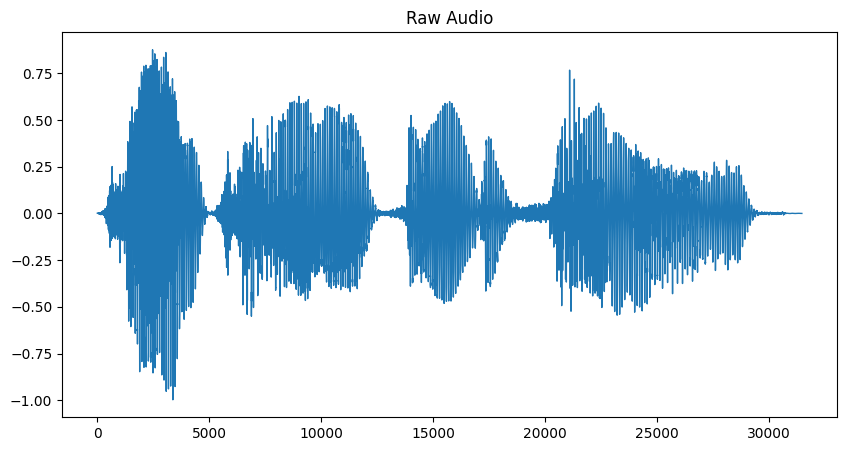

In [13]:
y,sr = librosa.load("/content/drive/MyDrive/ASVspoof2019_root/LA/ASVspoof2019_LA_eval/flac/LA_E_2834763.flac")
print(y, sr)
pd.Series(y).plot(figsize = (10,5), lw = 1, title= "Raw Audio")
plt.show()

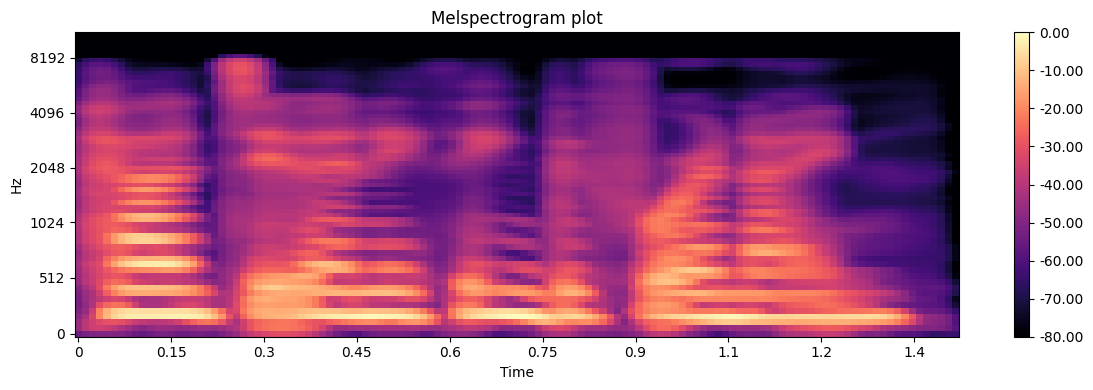

In [14]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels =64, hop_length=256)
log_mel = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(12, 4))
img = librosa.display.specshow(
    log_mel,
    sr=sr,
    hop_length=256,
    x_axis='time',
    y_axis='mel',
    fmax=sr // 2,
    ax=ax
)
ax.set_title("Melspectrogram plot")
ax.set
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.tight_layout()
plt.show()

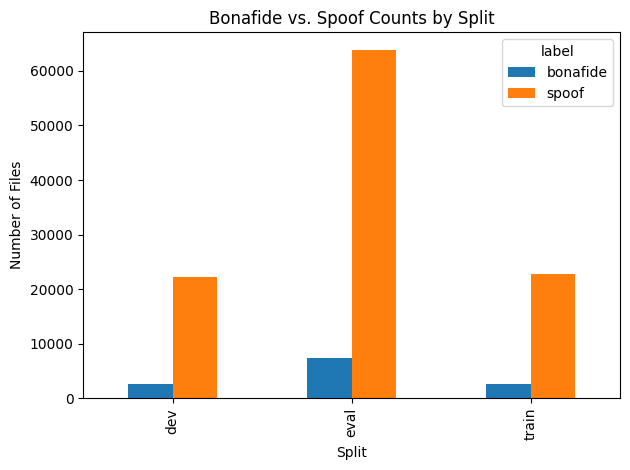

In [15]:
import matplotlib.pyplot as plt


# 1) Make a grouped bar chart
ax = counts.plot(kind="bar")

# 2) Tidy up the labels
ax.set_title("Bonafide vs. Spoof Counts by Split")
ax.set_xlabel("Split")
ax.set_ylabel("Number of Files")

# 3) Improve layout and show
plt.tight_layout()
plt.show()

## Spoof Audio Data

In [16]:
from tqdm import tqdm

In [17]:
# Load dataset
df = meta.copy()

In [18]:
# Randomly select one bonafide and one spoof sample
bonafide_sample = df[df['label'] == 'bonafide'].sample(1).iloc[0]
spoof_sample    = df[df['label'] == 'spoof'].sample(1).iloc[0]

def load_audio_data(row):
    y, sr = librosa.load(row['path'], sr=16000)
    return y, sr, row['file_id'], row['label']

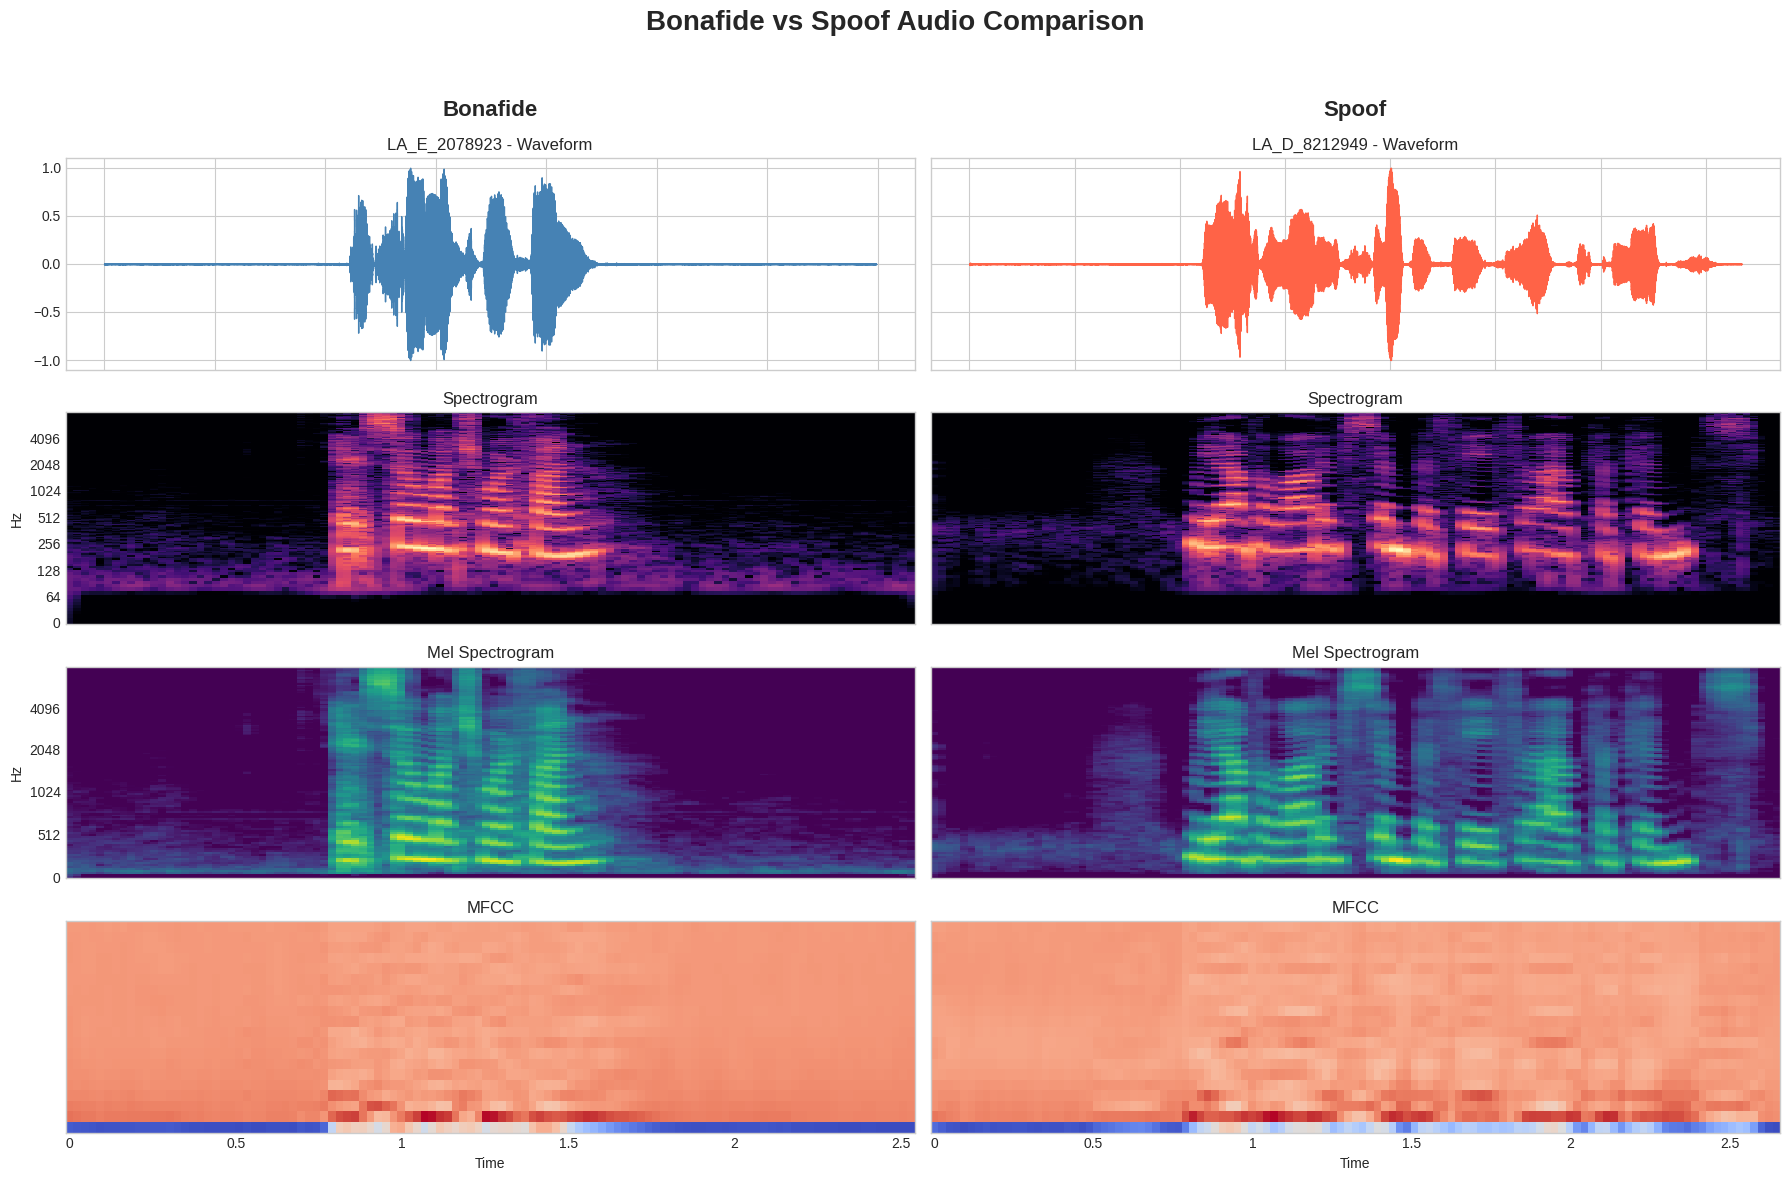

In [19]:
def plot_audio_comparison(y1, sr1, title1, y2, sr2, title2):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(4, 2, figsize=(18, 12))
    fig.suptitle("Bonafide vs Spoof Audio Comparison", fontsize=20, weight='bold')

    # --- Waveform ---
    librosa.display.waveshow(y1, sr=sr1, ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title(f"{title1} - Waveform")
    librosa.display.waveshow(y2, sr=sr2, ax=axes[0, 1], color='tomato')
    axes[0, 1].set_title(f"{title2} - Waveform")

    # --- Spectrogram ---
    D1 = np.abs(librosa.stft(y1))
    D2 = np.abs(librosa.stft(y2))
    librosa.display.specshow(librosa.amplitude_to_db(D1, ref=np.max),
                             sr=sr1, x_axis='time', y_axis='log', cmap='magma', ax=axes[1, 0])
    librosa.display.specshow(librosa.amplitude_to_db(D2, ref=np.max),
                             sr=sr2, x_axis='time', y_axis='log', cmap='magma', ax=axes[1, 1])
    axes[1, 0].set_title("Spectrogram")
    axes[1, 1].set_title("Spectrogram")

    # --- Mel Spectrogram ---
    S1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128)
    S2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128)
    librosa.display.specshow(librosa.power_to_db(S1, ref=np.max),
                             sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axes[2, 0])
    librosa.display.specshow(librosa.power_to_db(S2, ref=np.max),
                             sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axes[2, 1])
    axes[2, 0].set_title("Mel Spectrogram")
    axes[2, 1].set_title("Mel Spectrogram")

    # --- MFCC ---
    mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=20)
    mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=20)
    librosa.display.specshow(mfcc1, x_axis='time', cmap='coolwarm', ax=axes[3, 0])
    librosa.display.specshow(mfcc2, x_axis='time', cmap='coolwarm', ax=axes[3, 1])
    axes[3, 0].set_title("MFCC")
    axes[3, 1].set_title("MFCC")

    # Shared labels
    for ax in axes.flat:
        ax.label_outer()

    # Annotate column headers
    axes[0, 0].annotate("Bonafide", xy=(0.5, 1.2), xycoords='axes fraction',
                        ha='center', fontsize=16, weight='bold')
    axes[0, 1].annotate("Spoof", xy=(0.5, 1.2), xycoords='axes fraction',
                        ha='center', fontsize=16, weight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Load audio data and plot
y1, sr1, fid1, lbl1 = load_audio_data(bonafide_sample)
y2, sr2, fid2, lbl2 = load_audio_data(spoof_sample)

plot_audio_comparison(y1, sr1, fid1, y2, sr2, fid2)


In [20]:
# --- Randomly select one bonafide and one spoof ---
bonafide_sample = df[df['label'] == 'bonafide'].sample(1).iloc[0]
spoof_sample    = df[df['label'] == 'spoof'].sample(1).iloc[0]

def load_audio(row):
    y, sr = librosa.load(row['path'], sr=16000)
    return y, sr, row['file_id'], row['label']

In [21]:
def compute_audio_stats(y, sr):
    """Compute useful descriptive stats."""
    duration = librosa.get_duration(y=y, sr=sr)
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    return {
        "Duration (s)": round(duration, 2),
        "RMS Energy": round(rms, 5),
        "Zero-Crossing Rate": round(zcr, 5),
        "Spectral Centroid": round(centroid, 2),
        "Bandwidth": round(bandwidth, 2)
    }

In [22]:
# --- Load audio and stats ---
y1, sr1, fid1, lbl1 = load_audio_data(bonafide_sample)
y2, sr2, fid2, lbl2 = load_audio(spoof_sample)

stats1 = compute_audio_stats(y1, sr1)
stats2 = compute_audio_stats(y2, sr2)

In [23]:
# --- Print audio statistics side-by-side ---
stats_df = pd.DataFrame([stats1, stats2], index=["Bonafide", "Spoof"]).T
display(stats_df.style.set_caption("Audio Feature Summary Comparison")
                    .background_gradient(axis=0, cmap="coolwarm")
                    .format(precision=4))

,Bonafide,Spoof
Duration (s),4.1800,7.0800
RMS Energy,0.0971,0.0931
Zero-Crossing Rate,0.1567,0.1230
Spectral Centroid,2086.7100,1963.7900
Bandwidth,1773.1700,1701.9100


In [24]:
df['label'] = df['label'].replace({'bonafide': 0, 'spoof': 1})

In [25]:
df['label'].value_counts()


,count
label,
1,108978
0,12483


In [26]:
# H Load a single audio file
def load_audio(file_path, sr=16000):
    """
    Load audio from a FLAC file.
    Returns: audio waveform (y) and sampling rate (sr)
    """
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

In [27]:
# Helper: Extract MFCC features (commonly used for spoof detection)
def extract_features(y, sr):
    """
    Extract MFCC + delta + delta-delta features and return the mean.
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    # Combine and take mean across time axis
    combined = np.vstack([mfcc, delta, delta2])
    features = np.mean(combined.T, axis=0)
    return features

The code improves speed by using multiprocessing to process audio files in parallel. Each task contains a file path and label, which are sent to worker processes. Each worker loads the audio, extracts features, and returns results. Valid outputs are collected into lists for later machine learning model training.

In [28]:
from multiprocessing import Pool
from tqdm import tqdm
import os

def process_file(args):
    file_path, label = args

    if not os.path.exists(file_path):
        return None

    try:
        audio, sr = load_audio(file_path)
        feats = extract_features(audio, sr)
        return feats, label
    except:
        return None

# Convert dataframe rows to simple tuples (picklable)
tasks = list(zip(df['path'], df['label']))

with Pool(processes=8) as p:
    results = list(tqdm(p.imap(process_file, tasks), total=len(tasks)))




100%|██████████| 121461/121461 [1:43:49<00:00, 19.50it/s]


In [29]:
X = [r[0] for r in results if r]
y = [r[1] for r in results if r]

In [30]:

X_spoof = np.array(X)
y_spoof= np.array(y)

print("Feature matrix shape:", X_spoof.shape)
print("Labels shape:", y_spoof.shape)
print("Unique labels:", np.unique(y_spoof))


Feature matrix shape: (121461, 60)
Labels shape: (121461,)
Unique labels: [0 1]


# Feature Engineering

In [31]:
#cell1
# Normalize features (critical for MLP performance)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_spoof = scaler.fit_transform(X_spoof)


In [32]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

In [33]:
if not torch.is_tensor(X_spoof):
    print('Conveting X Spoof to tensor')
    X_spoof = torch.tensor(X_spoof,dtype=torch.float32)
    print('Complete')

Conveting X Spoof to tensor
Complete


In [34]:
if not torch.is_tensor(y_spoof):
    print('Conveting y Spoof to tensor')
    y_spoof = torch.tensor(y_spoof,dtype=torch.float32)
    print('Complete')

Conveting y Spoof to tensor
Complete


In [35]:
# ------------------------------------------------------
# Split into train, validation, and test sets
# ------------------------------------------------------
# 70% train, 15% val, 15% test
X_train_spoof, X_temp_spoof, y_train_spoof, y_temp_spoof = train_test_split(
    X_spoof, y_spoof,
    stratify=y_spoof,
    test_size=0.30,
    random_state=42
)

In [36]:

X_val_spoof, X_test_spoof, y_val_spoof, y_test_spoof = train_test_split(
    X_temp_spoof, y_temp_spoof,
    stratify=y_temp_spoof,
    test_size=0.15,  # 15% each
    random_state=42
)


In [37]:
# ------------------------------------------------------
# ensure tensors are detached and float32
# ------------------------------------------------------
X_train_spoof = X_train_spoof.clone().detach().float()
y_train_spoof = y_train_spoof.clone().detach().float()
X_val_spoof   = X_val_spoof.clone().detach().float()
y_val_spoof   = y_val_spoof.clone().detach().float()
X_test_spoof  = X_test_spoof.clone().detach().float()
y_test_spoof  = y_test_spoof.clone().detach().float()

In [38]:
# ------------------------------------------------------
# Wrap tensors into TensorDatasets
# ------------------------------------------------------
train_dataset_spoof = TensorDataset(X_train_spoof, y_train_spoof)
val_dataset_spoof   = TensorDataset(X_val_spoof, y_val_spoof)
test_dataset_spoof  = TensorDataset(X_test_spoof, y_test_spoof)

In [39]:
# ------------------------------------------------------
#  Create DataLoaders
# ------------------------------------------------------
train_loader_spoof = DataLoader(train_dataset_spoof, batch_size=32, shuffle=True)
val_loader_spoof   = DataLoader(val_dataset_spoof, batch_size=32, shuffle=False)
test_loader_spoof  = DataLoader(test_dataset_spoof, batch_size=32, shuffle=False)

# Modeling

## Baseline Model

In [40]:
import torch.nn as nn

In [41]:
class BaselineNN(nn.Module):
     def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

     def forward(self, x):
        return self.net(x)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
device

device(type='cpu')

In [44]:
base_model = BaselineNN(X_spoof.shape[1]).to(device)

In [45]:
# 1.  class imbalance ratio
pos_weight_value = (len(y_train_spoof) - y_train_spoof.sum()) / y_train_spoof.sum()
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

# 2. Use BCEWithLogitsLoss instead of BCELoss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 3. Define optimizer
optimizer = torch.optim.AdamW(base_model.parameters(), lr=1e-4)

In [46]:
import time
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix, classification_report
)

In [47]:
num_epochs = 50

In [48]:
def compute_eer(y_true, y_scores):
    """Compute Equal Error Rate (EER) from true labels and prediction scores."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

In [49]:
def compute_asr(y_true, y_pred):
    """Compute Attack Success Rate (spoof=1 classified as bonafide=0)."""
    malicious = (np.array(y_true) == 1)
    if malicious.sum() == 0:
        return 0.0
    misclassified = np.logical_and(malicious, np.array(y_pred) == 0)
    return misclassified.sum() / malicious.sum()

In [50]:
def compute_far(y_true, y_pred):
    # FAR = False Accept / total negatives
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    false_accepts = np.sum((y_true == 0) & (y_pred == 1))
    total_negatives = np.sum(y_true == 0)
    return false_accepts / total_negatives if total_negatives > 0 else 0.0



In [51]:
def compute_frr(y_true, y_pred):
    # FRR = False Reject / total positives
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    false_rejects = np.sum((y_true == 1) & (y_pred == 0))
    total_positives = np.sum(y_true == 1)
    return false_rejects / total_positives if total_positives > 0 else 0.0


In [52]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Compute weights
classes = np.array([0,1])
class_weights = compute_class_weight('balanced', classes=classes, y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [53]:
# Track final metrics
final_y_true, final_y_pred, final_y_scores = [], [], []
latencies, eers, asrs = [], [], []

## Baseline Model Training

In [54]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np
import time

spoof_epoch_metrics = []   # list to store metrics for each epoch

for epoch in range(num_epochs):

    # ----- TRAIN -----
    base_model.train()
    total_loss = 0

    for Xb, yb in train_loader_spoof:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        preds = base_model(Xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_spoof)

    # ----- VALIDATION -----
    base_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0
    start_time = time.time()

    with torch.no_grad():
        for Xv, yv in val_loader_spoof:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1)
            preds = base_model(Xv)
            loss = criterion(preds, yv)
            val_loss += loss.item()

            probs = torch.sigmoid(preds)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy())
            y_pred.extend(preds_class.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_spoof)
    avg_latency = (end_time - start_time) / len(val_loader_spoof.dataset)

    # ----- METRICS -----
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except:
        roc_auc = 0.0

    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    spoof_epoch_metrics.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    })

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | "
          f"Prec: {prec:.4f} | "
          f"Rec: {rec:.4f} | "
          f"F1: {f1:.4f} | "
          f"EER: {eer:.4f} | "
          f"ASR: {asr:.4f} | "
          f"FAR: {far:.4f} | "
          f"FRR: {frr:.4f} | "
          f"ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample")
    print('')

    final_y_true = y_true
    final_y_pred = y_pred
    final_y_scores = y_scores


Epoch 01 | Train Loss: 0.0627 | Val Loss: 0.0433 | Acc: 0.8726 | Prec: 0.9958 | Rec: 0.8617 | F1: 0.9239 | EER: 0.0845 | ASR: 0.1383 | FAR: 0.0320 | FRR: 0.1383 | ROC-AUC: 0.9742 | Latency: 0.04 ms/sample

Epoch 02 | Train Loss: 0.0470 | Val Loss: 0.0369 | Acc: 0.8924 | Prec: 0.9967 | Rec: 0.8831 | F1: 0.9364 | EER: 0.0682 | ASR: 0.1169 | FAR: 0.0258 | FRR: 0.1169 | ROC-AUC: 0.9820 | Latency: 0.04 ms/sample

Epoch 03 | Train Loss: 0.0425 | Val Loss: 0.0332 | Acc: 0.9105 | Prec: 0.9960 | Rec: 0.9039 | F1: 0.9477 | EER: 0.0625 | ASR: 0.0961 | FAR: 0.0314 | FRR: 0.0961 | ROC-AUC: 0.9845 | Latency: 0.06 ms/sample

Epoch 04 | Train Loss: 0.0391 | Val Loss: 0.0304 | Acc: 0.9254 | Prec: 0.9956 | Rec: 0.9209 | F1: 0.9568 | EER: 0.0562 | ASR: 0.0791 | FAR: 0.0355 | FRR: 0.0791 | ROC-AUC: 0.9870 | Latency: 0.04 ms/sample

Epoch 05 | Train Loss: 0.0367 | Val Loss: 0.0272 | Acc: 0.9367 | Prec: 0.9953 | Rec: 0.9338 | F1: 0.9636 | EER: 0.0518 | ASR: 0.0662 | FAR: 0.0383 | FRR: 0.0662 | ROC-AUC: 0.98

In [55]:
# Convert to DataFrame
spoof_epoch_metrics = pd.DataFrame(spoof_epoch_metrics)

spoof_epoch_metrics.head()

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.062671,0.043345,0.872599,0.995758,0.861677,0.923878,0.084511,0.974185,0.138323,0.032045,0.138323,0.000036
1,2,0.047046,0.036900,0.892422,0.996670,0.883051,0.936427,0.068175,0.982050,0.116949,0.025762,0.116949,0.000036
2,3,0.042517,0.033174,0.910503,0.996035,0.903850,0.947706,0.062520,0.984544,0.096150,0.031417,0.096150,0.000057
3,4,0.039097,0.030383,0.925387,0.995604,0.920907,0.956800,0.056236,0.986956,0.079093,0.035501,0.079093,0.000035
4,5,0.036666,0.027221,0.936655,0.995321,0.933789,0.963574,0.051838,0.989160,0.066211,0.038329,0.066211,0.000042


In [56]:
print("Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         0.0     0.8106    0.9761    0.8857      3183
         1.0     0.9972    0.9739    0.9854     27790

    accuracy                         0.9741     30973
   macro avg     0.9039    0.9750    0.9355     30973
weighted avg     0.9780    0.9741    0.9752     30973



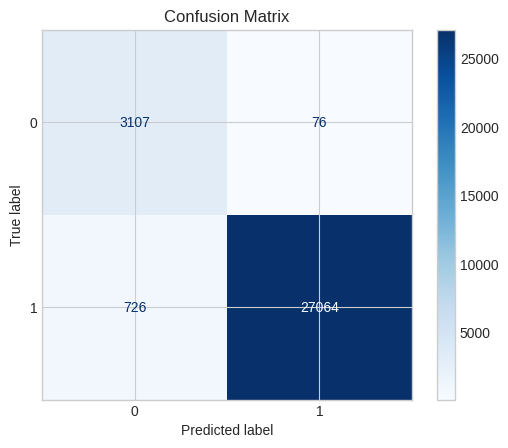

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix")
plt.show()


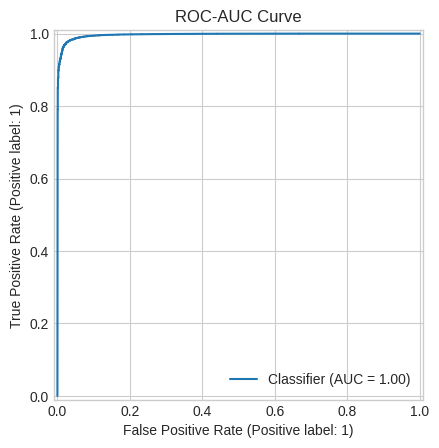

In [58]:
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title("ROC-AUC Curve")
plt.show()


## PGD Model

In [59]:
import copy
import torch.optim as optim

In [60]:
# -------------------------
# Copy baseline model
# -------------------------
pgd_model = copy.deepcopy(base_model)  # now pgd_model is independent


In [61]:
# Set device
pgd_model = pgd_model.to(device)

In [62]:
# Define PGD attack per batch
def pgd_attack_batch(model, X, y=None, eps=0.03, alpha=0.007, iters=20, device='cpu',
                     clamp_min=0.0, clamp_max=1.0, targeted=False):
    model.eval()
    X_adv = X.detach().clone().to(device)
    X_orig = X.detach().clone().to(device)

    if y is None:
        with torch.no_grad():
            logits = model(X_adv)
            probs = torch.sigmoid(logits)
            y = (probs > 0.5).float()
    y = y.to(device).float()

    X_adv.requires_grad = True

    for i in range(iters):
        logits = model(X_adv)
        loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
        loss = loss_fn(logits, y)
        if targeted:
            loss = -loss

        model.zero_grad()
        if X_adv.grad is not None:
            X_adv.grad.data.zero_()
        loss.backward()
        grad_sign = X_adv.grad.data.sign()
        X_adv = X_adv.detach() + alpha * grad_sign
        delta = torch.clamp(X_adv - X_orig, min=-eps, max=eps)
        X_adv = torch.clamp(X_orig + delta, min=clamp_min, max=clamp_max).detach()
        X_adv.requires_grad = True

    return X_adv.detach()

In [63]:

num_epochs_adv = 50
optimizer_adv = optim.Adam(pgd_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
spoof_epoch_metrics_adv = []

In [64]:
for epoch in range(num_epochs_adv):
    pgd_model.train()
    total_loss = 0
    for Xb, yb in train_loader_spoof:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()

        # Create adversarial batch
        Xb_adv = pgd_attack_batch(pgd_model, Xb, y=yb, eps=0.03, alpha=0.007, iters=10, device=device)

        # Forward + backward
        preds = pgd_model(Xb_adv)
        loss = criterion(preds, yb)
        optimizer_adv.zero_grad()
        loss.backward()
        optimizer_adv.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_spoof)

    # ----- Validation -----
    pgd_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0.0
    start_time = time.time()
    with torch.no_grad():
        for Xv, yv in val_loader_spoof:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1).float()

            # Evaluate on clean validation (optional: can also attack validation)
            logits = pgd_model(Xv)
            val_loss += criterion(logits, yv).item()
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy().flatten().tolist())
            y_pred.extend(preds_class.cpu().numpy().flatten().tolist())
            y_scores.extend(probs.cpu().numpy().flatten().tolist())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_spoof)
    avg_latency = (end_time - start_time) / len(val_loader_spoof.dataset)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    epoch_metrics = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    }
    spoof_epoch_metrics_adv.append(epoch_metrics)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | "
          f"EER: {eer:.4f} | ASR: {asr:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample")
    print('')

Epoch 1 | Train Loss: 0.1726 | Val Loss: 1.0317 | Acc: 0.9003 | Prec: 0.9040 | Rec: 0.9946 | F1: 0.9471 | EER: 0.1681 | ASR: 0.0054 | FAR: 0.9224 | FRR: 0.0054 | ROC-AUC: 0.8536 | Latency: 0.05 ms/sample

Epoch 2 | Train Loss: 0.1337 | Val Loss: 1.4210 | Acc: 0.8994 | Prec: 0.9035 | Rec: 0.9941 | F1: 0.9466 | EER: 0.3101 | ASR: 0.0059 | FAR: 0.9268 | FRR: 0.0059 | ROC-AUC: 0.7885 | Latency: 0.04 ms/sample

Epoch 3 | Train Loss: 0.1213 | Val Loss: 1.7760 | Acc: 0.8984 | Prec: 0.9017 | Rec: 0.9953 | F1: 0.9462 | EER: 0.4364 | ASR: 0.0047 | FAR: 0.9475 | FRR: 0.0047 | ROC-AUC: 0.7308 | Latency: 0.04 ms/sample

Epoch 4 | Train Loss: 0.1119 | Val Loss: 2.1837 | Acc: 0.8976 | Prec: 0.9000 | Rec: 0.9966 | F1: 0.9458 | EER: 0.5504 | ASR: 0.0034 | FAR: 0.9673 | FRR: 0.0034 | ROC-AUC: 0.6824 | Latency: 0.04 ms/sample

Epoch 5 | Train Loss: 0.1039 | Val Loss: 2.6436 | Acc: 0.8966 | Prec: 0.8991 | Rec: 0.9967 | F1: 0.9454 | EER: 0.6642 | ASR: 0.0033 | FAR: 0.9771 | FRR: 0.0033 | ROC-AUC: 0.6323 | 

In [65]:
spoof_epoch_metrics_adv = pd.DataFrame(spoof_epoch_metrics_adv)

In [66]:
spoof_epoch_metrics_adv.head()

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.172560,1.031659,0.900333,0.903974,0.994566,0.947109,0.168080,0.853562,0.005434,0.922400,0.005434,0.000048
1,2,0.133735,1.421044,0.899429,0.903516,0.994063,0.946629,0.310085,0.788457,0.005937,0.926799,0.005937,0.000038
2,3,0.121316,1.775980,0.898363,0.901676,0.995250,0.946155,0.436381,0.730849,0.004750,0.947534,0.004750,0.000039
3,4,0.111903,2.183724,0.897556,0.899951,0.996617,0.945821,0.550424,0.682427,0.003383,0.967326,0.003383,0.000037
4,5,0.103921,2.643593,0.896620,0.899052,0.996689,0.945356,0.664153,0.632346,0.003311,0.977066,0.003311,0.000038


In [67]:
final_y_true = y_true
final_y_pred = y_pred
final_y_scores = y_scores

In [68]:
print("Adversarially-trained Model Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))

Adversarially-trained Model Classification Report:
              precision    recall  f1-score   support

         0.0     0.5417    0.0041    0.0081      3183
         1.0     0.8976    0.9996    0.9458     27790

    accuracy                         0.8973     30973
   macro avg     0.7196    0.5018    0.4770     30973
weighted avg     0.8610    0.8973    0.8495     30973



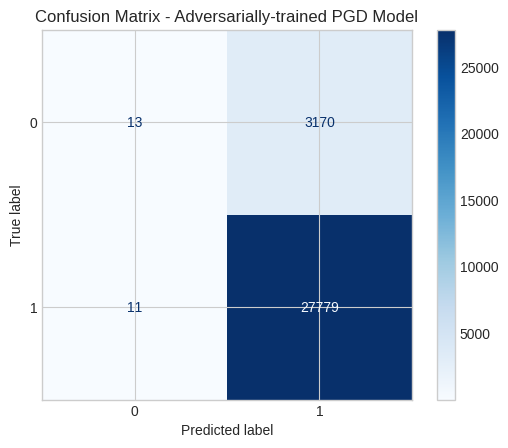

In [69]:
# Confusion matrix
cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix - Adversarially-trained PGD Model")
plt.show()

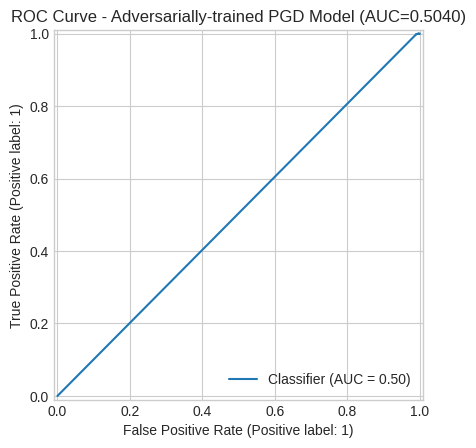

In [70]:
# ROC curve
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title(f"ROC Curve - Adversarially-trained PGD Model (AUC={roc_auc:.4f})")
plt.show()

## FGSM Model

In [71]:
fgsm_model = copy.deepcopy(base_model)
fgsm_model = fgsm_model.to(device)


In [72]:
def fgsm_attack(model, X, y, eps=0.03, device='cpu', clamp_min=0.0, clamp_max=1.0):
    """
    Performs FGSM attack on a batch X
    model: PyTorch model
    X: input batch [N,C,H,W] or [N,features]
    y: labels [N,1]
    eps: max perturbation
    """
    model.eval()
    X_adv = X.clone().detach().to(device)
    X_adv.requires_grad = True
    y = y.to(device).float()

    logits = model(X_adv)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    loss = loss_fn(logits, y)
    model.zero_grad()
    loss.backward()

    # FGSM step
    grad_sign = X_adv.grad.data.sign()
    X_adv = X_adv + eps * grad_sign
    X_adv = torch.clamp(X_adv, clamp_min, clamp_max).detach()

    return X_adv


In [73]:
num_epochs_fgsm = 50
optimizer_fgsm = optim.Adam(fgsm_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [74]:
spoof_epoch_metrics_fgsm = []

In [75]:
for epoch in range(num_epochs_fgsm):
    fgsm_model.train()
    total_loss = 0
    for Xb, yb in train_loader_spoof:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()

        # Generate FGSM adversarial batch
        Xb_adv = fgsm_attack(fgsm_model, Xb, yb, eps=0.03, device=device)

        # Forward + backward
        preds = fgsm_model(Xb_adv)
        loss = criterion(preds, yb)
        optimizer_fgsm.zero_grad()
        loss.backward()
        optimizer_fgsm.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_spoof)

    # ----- Validation -----
    fgsm_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0.0
    start_time = time.time()
    with torch.no_grad():
        for Xv, yv in val_loader_spoof:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1).float()

            logits = fgsm_model(Xv)
            val_loss += criterion(logits, yv).item()
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy().flatten().tolist())
            y_pred.extend(preds_class.cpu().numpy().flatten().tolist())
            y_scores.extend(probs.cpu().numpy().flatten().tolist())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_spoof)
    avg_latency = (end_time - start_time) / len(val_loader_spoof.dataset)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    epoch_metrics = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    }
    spoof_epoch_metrics_fgsm.append(epoch_metrics)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | "
          f"EER: {eer:.4f} | ASR: {asr:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample")
    print('')


Epoch 1 | Train Loss: 0.1426 | Val Loss: 1.1323 | Acc: 0.9004 | Prec: 0.9065 | Rec: 0.9913 | F1: 0.9470 | EER: 0.2083 | ASR: 0.0087 | FAR: 0.8926 | FRR: 0.0087 | ROC-AUC: 0.8378 | Latency: 0.04 ms/sample

Epoch 2 | Train Loss: 0.0960 | Val Loss: 1.5755 | Acc: 0.8984 | Prec: 0.9045 | Rec: 0.9914 | F1: 0.9460 | EER: 0.3622 | ASR: 0.0086 | FAR: 0.9142 | FRR: 0.0086 | ROC-AUC: 0.7667 | Latency: 0.04 ms/sample

Epoch 3 | Train Loss: 0.0808 | Val Loss: 2.0716 | Acc: 0.8976 | Prec: 0.9018 | Rec: 0.9942 | F1: 0.9457 | EER: 0.5134 | ASR: 0.0058 | FAR: 0.9456 | FRR: 0.0058 | ROC-AUC: 0.7002 | Latency: 0.05 ms/sample

Epoch 4 | Train Loss: 0.0701 | Val Loss: 2.6387 | Acc: 0.8972 | Prec: 0.8994 | Rec: 0.9970 | F1: 0.9457 | EER: 0.6516 | ASR: 0.0030 | FAR: 0.9739 | FRR: 0.0030 | ROC-AUC: 0.6413 | Latency: 0.05 ms/sample

Epoch 5 | Train Loss: 0.0618 | Val Loss: 2.8561 | Acc: 0.8973 | Prec: 0.8997 | Rec: 0.9967 | F1: 0.9457 | EER: 0.6839 | ASR: 0.0033 | FAR: 0.9702 | FRR: 0.0033 | ROC-AUC: 0.6291 | 

In [76]:
spoof_epoch_metrics_fgsm = pd.DataFrame(spoof_epoch_metrics_fgsm)

In [77]:
spoof_epoch_metrics_fgsm.head()

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.142559,1.132319,0.900429,0.906509,0.991256,0.946990,0.208294,0.837791,0.008744,0.892554,0.008744,0.000038
1,2,0.095951,1.575546,0.898363,0.904471,0.991436,0.945959,0.362237,0.766667,0.008564,0.914232,0.008564,0.000040
2,3,0.080848,2.071636,0.897588,0.901756,0.994171,0.945711,0.513352,0.700209,0.005829,0.945649,0.005829,0.000047
3,4,0.070113,2.638685,0.897233,0.899374,0.997013,0.945680,0.651587,0.641259,0.002987,0.973924,0.002987,0.000054
4,5,0.061831,2.856056,0.897330,0.899695,0.996689,0.945712,0.683946,0.629070,0.003311,0.970154,0.003311,0.000037


In [78]:
final_y_true = y_true
final_y_pred = y_pred
final_y_scores = y_scores

In [79]:
print("FGSM Adversarially-trained Model Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))

FGSM Adversarially-trained Model Classification Report:
              precision    recall  f1-score   support

         0.0     0.3913    0.0057    0.0111      3183
         1.0     0.8977    0.9990    0.9456     27790

    accuracy                         0.8969     30973
   macro avg     0.6445    0.5023    0.4784     30973
weighted avg     0.8456    0.8969    0.8496     30973



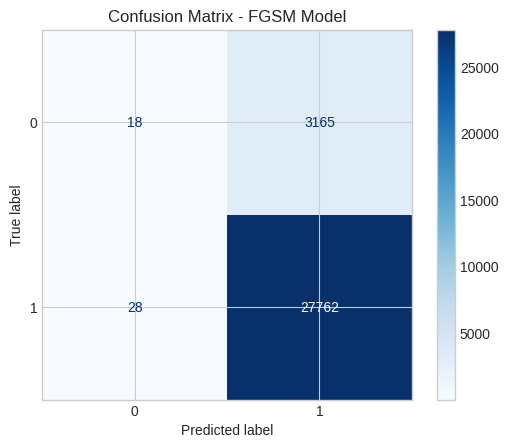

In [80]:
# Confusion matrix
cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix - FGSM Model")
plt.show()



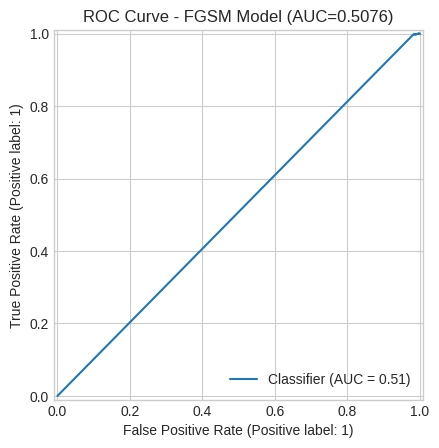

In [81]:
# ROC curve
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title(f"ROC Curve - FGSM Model (AUC={roc_auc:.4f})")
plt.show()


## Comparison of baseline, PGD, and FGSM models - robustness.

In [82]:
# Add a 'model' column to each
spoof_epoch_metrics['model'] = 'Baseline'
spoof_epoch_metrics_adv['model'] = 'PGD'
spoof_epoch_metrics_fgsm['model'] = 'FGSM'

In [83]:
# Combine all into one DataFrame
df_comparison = pd.concat([spoof_epoch_metrics, spoof_epoch_metrics_adv, spoof_epoch_metrics_fgsm], ignore_index=True)


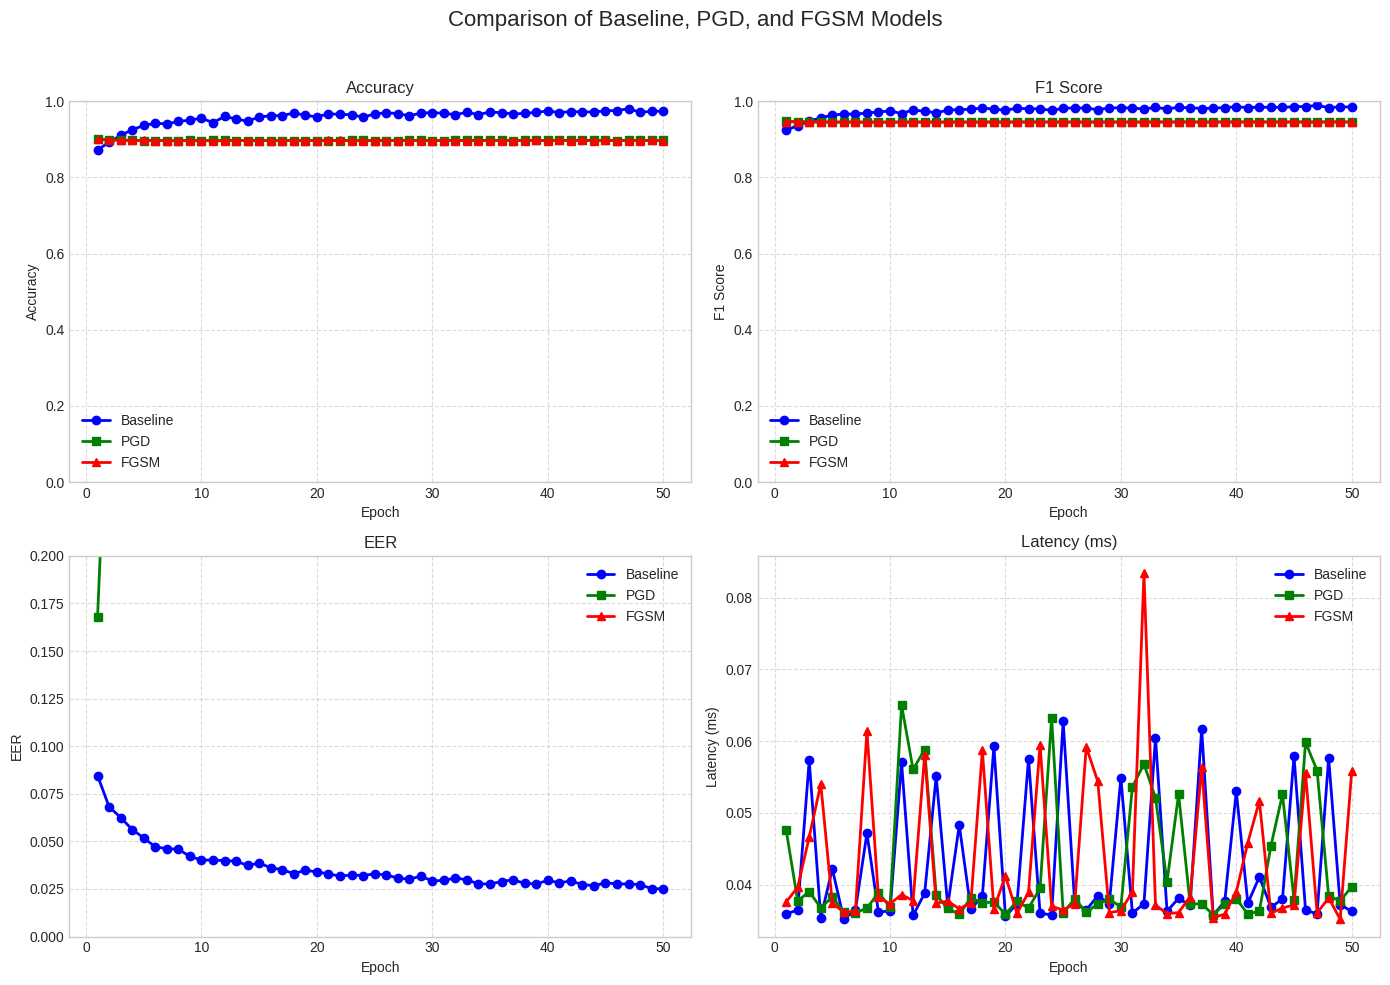

In [84]:
import matplotlib.pyplot as plt

# Define colors and markers for consistency
colors = {'Baseline':'blue', 'PGD':'green', 'FGSM':'red'}
markers = {'Baseline':'o', 'PGD':'s', 'FGSM':'^'}

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Comparison of Baseline, PGD, and FGSM Models', fontsize=16)

metrics = ['accuracy','f1_score','eer','latency_per_sample']
ylabels = ['Accuracy','F1 Score','EER','Latency (ms)']
ylim_vals = [(0,1),(0,1),(0,0.2),None]  # set limits for first three, last auto

for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]
    ylabel = ylabels[i]
    ylim = ylim_vals[i]

    for model_name in df_comparison['model'].unique():
        model_data = df_comparison[df_comparison['model'] == model_name]
        y_values = model_data[metric]
        if metric == 'latency_per_sample':  # convert to ms
            y_values = y_values * 1000
        ax.plot(model_data['epoch'], y_values, marker=markers[model_name],
                color=colors[model_name], label=model_name, linewidth=2)

    ax.set_title(ylabel)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [85]:
# -------------------------
# Display summary table for last epoch
# -------------------------
summary_table = df_comparison[df_comparison['epoch']==df_comparison['epoch'].max()]
print("Comparison Summary (Last Epoch Metrics):")
summary_table[['model','accuracy','precision','recall','f1_score','eer','roc_auc','asr','far','frr','latency_per_sample']]


Comparison Summary (Last Epoch Metrics):


,model,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
49,Baseline,0.974106,0.997200,0.973875,0.985400,0.025134,0.996688,0.026125,0.023877,0.026125,0.000036
99,PGD,0.897298,0.897573,0.999604,0.945845,0.990261,0.504008,0.000396,0.995916,0.000396,0.000040
149,FGSM,0.896910,0.897662,0.998992,0.945621,0.982092,0.507639,0.001008,0.994345,0.001008,0.000056


# WILD Data

In [86]:
base_path = '/content/drive/MyDrive/WILD'
#base_path = '/content/drive/MyDrive//media/sf_SOUKYA-THESIS/WILD'

In [87]:
# Optimized feature extraction
def extract_features(audio, sr, n_mfcc=20, n_lfcc=20, n_mels=32):
    """
    Extracts MFCC, LFCC, log-mel spectrogram, and spectrogram features efficiently.
    CQCC and embeddings are skipped for speed.
    """
    # Compute STFT once
    S = np.abs(librosa.stft(audio))**2
    S_log = np.log(S + 1e-10)

    # 1. MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc.T, axis=0)

    # 2. LFCC (DCT of log power spectrum)
    lfcc = dct(S_log, axis=0, norm='ortho')
    lfcc = np.mean(lfcc[:n_lfcc, :], axis=1)

    # 3. Log-Mel Spectrogram
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel)
    logmel = np.mean(logmel.T, axis=0)

    # 4. Spectrogram magnitude
    spec = np.mean(S.T, axis=0)

    # Combine all features
    features = np.concatenate([mfcc, lfcc, logmel, spec])
    return features


In [88]:
# Worker function for multiprocessing
def process_file(args):
    path, label = args
    try:
        audio, sr = librosa.load(path, sr=16000, mono=True)  # Fixed sample rate for consistency
        feat = extract_features(audio, sr)
        return feat, label
    except Exception as e:
        return None  # skip files that fail

In [89]:
# Load dataset and prepare tasks
def load_audio_dataset(base_path):
    X, y = [], []
    real_path = os.path.join(base_path, "real")
    fake_path = os.path.join(base_path, "fake")

    real_files = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(".wav")]
    fake_files = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(".wav")]

    tasks = [(f, 0) for f in real_files] + [(f, 1) for f in fake_files]

    # Use multiprocessing
    with Pool(processes=8) as p:
        results = list(tqdm(p.imap(process_file, tasks), total=len(tasks)))

    # Collect valid results
    X = [r[0] for r in results if r]
    y = [r[1] for r in results if r]

    return np.array(X), np.array(y)


In [90]:
X_wild, y_wild = load_audio_dataset(base_path)

100%|██████████| 31779/31779 [40:15<00:00, 13.15it/s]


In [91]:
print("Feature matrix shape:", X_wild.shape)
print("Labels shape:", y_wild.shape)
print("Unique labels:", np.unique(y_wild))

Feature matrix shape: (31779, 1097)
Labels shape: (31779,)
Unique labels: [0 1]


## Feature Engineering

In [92]:
scaler = StandardScaler()
X_wild = scaler.fit_transform(X_wild)

In [93]:
if not torch.is_tensor(X_wild):
    print('Conveting X Wild to tensor')
    X_wild = torch.tensor(X_wild,dtype=torch.float32)
    print('Complete')

Conveting X Wild to tensor
Complete


In [94]:
if not torch.is_tensor(y_wild):
    print('Conveting y Wild to tensor')
    y_wild = torch.tensor(y_wild,dtype=torch.float32)
    print('Complete')

Conveting y Wild to tensor
Complete


In [95]:
# ------------------------------------------------------
# Split into train, validation, and test sets
# ------------------------------------------------------
# 70% train, 15% val, 15% test
X_train_wild, X_temp_wild, y_train_wild, y_temp_wild = train_test_split(
    X_wild, y_wild,
    stratify=y_wild,
    test_size=0.30,
    random_state=42
)

In [96]:
X_val_wild, X_test_wild, y_val_wild, y_test_wild = train_test_split(
    X_temp_wild, y_temp_wild,
    stratify=y_temp_wild,
    test_size=0.15,  # 15% each
    random_state=42
)


In [97]:
type(X_train_wild)

torch.Tensor

In [98]:
# ------------------------------------------------------
# ensure tensors are detached and float32
# ------------------------------------------------------
X_train_wild = X_train_wild.clone().detach().float()
y_train_wild = y_train_wild.clone().detach().float()
X_val_wild   = X_val_wild.clone().detach().float()
y_val_wild   = y_val_wild.clone().detach().float()
X_test_wild  = X_test_wild.clone().detach().float()
y_test_wild  = y_test_wild.clone().detach().float()

In [99]:
train_dataset_wild = TensorDataset(X_train_wild, y_train_wild)
val_dataset_wild  = TensorDataset(X_val_wild, y_val_wild)
test_dataset_wild  = TensorDataset(X_test_wild, y_test_wild)

In [100]:
train_loader_wild = DataLoader(train_dataset_wild, batch_size=32, shuffle=True)
val_loader_wild   = DataLoader(val_dataset_wild, batch_size=32, shuffle=False)
test_loader_wild = DataLoader(test_dataset_wild, batch_size=32, shuffle=False)

### Baseline Model

In [101]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [102]:
# -------------------------
# Instantiate fresh model for new dataset
# -------------------------
new_input_dim = 1097
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create new model instance
base_model = BaselineNN(input_dim=new_input_dim).to(device)


In [103]:
new_input_dim = 1097  # number of features in new dataset
hidden_dim = 60       # keep as original

# Extract all layers after the first Linear
old_layers = list(base_model.net.children())[1:]

# Replace any BatchNorm1d layers to match hidden_dim
new_layers = []
for layer in old_layers:
    if isinstance(layer, nn.BatchNorm1d):
        new_layers.append(nn.BatchNorm1d(hidden_dim))
    else:
        new_layers.append(layer)

In [104]:
# 1.  class imbalance ratio
pos_weight_value = (len(y_train_spoof) - y_train_spoof.sum()) / y_train_spoof.sum()
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

# 2. Use BCEWithLogitsLoss instead of BCELoss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 3. Define optimizer
optimizer = torch.optim.AdamW(base_model.parameters(), lr=1e-4)

In [105]:
wild_epoch_metrics = []

for epoch in range(num_epochs):
    # ----- TRAIN -----
    base_model.train()
    total_loss = 0
    for Xb, yb in train_loader_wild:  # your DataLoader
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        preds = base_model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader_wild)

    # ----- VALIDATION -----
    base_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0
    start_time = time.time()

    with torch.no_grad():
        for Xv, yv in val_loader_wild:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1).float()
            preds = base_model(Xv)
            val_loss += criterion(preds, yv).item()

            probs = torch.sigmoid(preds)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy().flatten().tolist())
            y_pred.extend(preds_class.cpu().numpy().flatten().tolist())
            y_scores.extend(probs.cpu().numpy().flatten().tolist())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_wild)
    avg_latency = (end_time - start_time) / len(val_loader_wild.dataset)

    # ----- METRICS -----
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except:
        roc_auc = 0.0

    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    wild_epoch_metrics.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    })

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | "
          f"Prec: {prec:.4f} | "
          f"Rec: {rec:.4f} | "
          f"F1: {f1:.4f} | "
          f"EER: {eer:.4f} | "
          f"ASR: {asr:.4f} | "
          f"FAR: {far:.4f} | "
          f"FRR: {frr:.4f} | "
          f"ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample\n")
    print("")

Epoch 01 | Train Loss: 0.0655 | Val Loss: 0.0172 | Acc: 0.9824 | Prec: 0.9976 | Rec: 0.9549 | F1: 0.9758 | EER: 0.0149 | ASR: 0.0451 | FAR: 0.0014 | FRR: 0.0451 | ROC-AUC: 0.9959 | Latency: 0.13 ms/sample


Epoch 02 | Train Loss: 0.0131 | Val Loss: 0.0110 | Acc: 0.9867 | Prec: 0.9976 | Rec: 0.9665 | F1: 0.9818 | EER: 0.0092 | ASR: 0.0335 | FAR: 0.0014 | FRR: 0.0335 | ROC-AUC: 0.9985 | Latency: 0.08 ms/sample


Epoch 03 | Train Loss: 0.0098 | Val Loss: 0.0066 | Acc: 0.9898 | Prec: 0.9986 | Rec: 0.9738 | F1: 0.9861 | EER: 0.0088 | ASR: 0.0262 | FAR: 0.0008 | FRR: 0.0262 | ROC-AUC: 0.9981 | Latency: 0.07 ms/sample


Epoch 04 | Train Loss: 0.0092 | Val Loss: 0.0066 | Acc: 0.9910 | Prec: 0.9993 | Rec: 0.9764 | F1: 0.9877 | EER: 0.0100 | ASR: 0.0236 | FAR: 0.0004 | FRR: 0.0236 | ROC-AUC: 0.9976 | Latency: 0.08 ms/sample


Epoch 05 | Train Loss: 0.0083 | Val Loss: 0.0060 | Acc: 0.9935 | Prec: 0.9980 | Rec: 0.9844 | F1: 0.9911 | EER: 0.0094 | ASR: 0.0156 | FAR: 0.0012 | FRR: 0.0156 | ROC-AUC: 

In [106]:
pd.DataFrame(wild_epoch_metrics).head()


,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.065474,0.017221,0.982352,0.997573,0.954862,0.975750,0.014931,0.995854,0.045138,0.001375,0.045138,0.000130
1,2,0.013059,0.010998,0.986672,0.997602,0.966479,0.981794,0.009234,0.998463,0.033521,0.001375,0.033521,0.000077
2,3,0.009849,0.006649,0.989757,0.998639,0.973780,0.986053,0.008841,0.998052,0.026220,0.000786,0.026220,0.000073
3,4,0.009225,0.006590,0.990991,0.999321,0.976435,0.987746,0.010020,0.997630,0.023565,0.000393,0.023565,0.000083
4,5,0.008323,0.005995,0.993459,0.997981,0.984401,0.991145,0.009430,0.998844,0.015599,0.001179,0.015599,0.000074


In [107]:
final_y_true = y_true
final_y_pred = y_pred
final_y_scores = y_scores

print("WILD Dataset Model Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))

WILD Dataset Model Classification Report:
              precision    recall  f1-score   support

         0.0     0.9910    0.9996    0.9953      5090
         1.0     0.9993    0.9847    0.9920      3013

    accuracy                         0.9941      8103
   macro avg     0.9952    0.9922    0.9936      8103
weighted avg     0.9941    0.9941    0.9941      8103



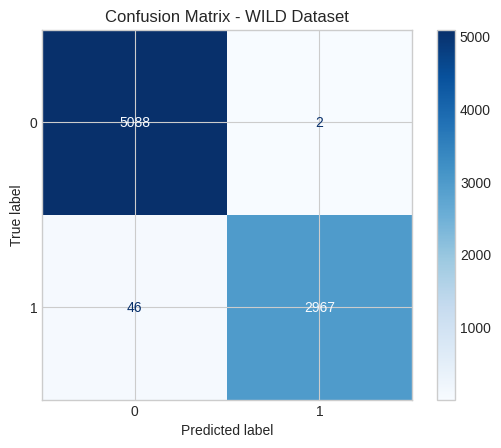

In [108]:
# Confusion matrix
cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix - WILD Dataset")
plt.show()

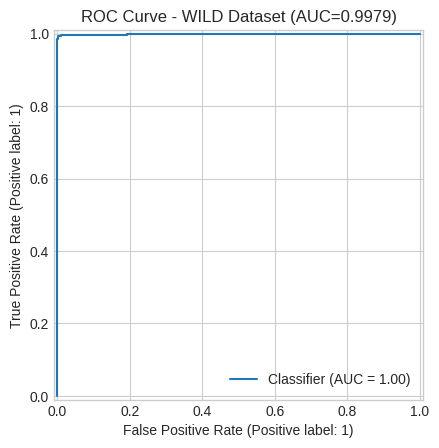

In [109]:
# ROC curve
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title(f"ROC Curve - WILD Dataset (AUC={roc_auc:.4f})")
plt.show()

### PGD Model

In [110]:
# Copy baseline model
# -------------------------
pgd_model = copy.deepcopy(base_model)  # now pgd_model is independent

In [111]:
# Set device
pgd_model = pgd_model.to(device)

In [112]:
wild_epoch_metrics_adv = []

In [113]:
for epoch in range(num_epochs_adv):
    pgd_model.train()
    total_loss = 0
    for Xb, yb in train_loader_wild:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()

        # Create adversarial batch
        Xb_adv = pgd_attack_batch(pgd_model, Xb, y=yb, eps=0.03, alpha=0.007, iters=10, device=device)

        # Forward + backward
        preds = pgd_model(Xb_adv)
        loss = criterion(preds, yb)
        optimizer_adv.zero_grad()
        loss.backward()
        optimizer_adv.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_wild)

    # ----- Validation -----
    pgd_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0.0
    start_time = time.time()
    with torch.no_grad():
        for Xv, yv in val_loader_wild:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1).float()

            # Evaluate on clean validation (optional: can also attack validation)
            logits = pgd_model(Xv)
            val_loss += criterion(logits, yv).item()
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy().flatten().tolist())
            y_pred.extend(preds_class.cpu().numpy().flatten().tolist())
            y_scores.extend(probs.cpu().numpy().flatten().tolist())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_wild)
    avg_latency = (end_time - start_time) / len(val_loader_wild.dataset)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    epoch_metrics = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    }
    wild_epoch_metrics_adv.append(epoch_metrics)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | "
          f"EER: {eer:.4f} | ASR: {asr:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample")
    print('')

Epoch 1 | Train Loss: 0.2366 | Val Loss: 0.0059 | Acc: 0.9941 | Prec: 0.9993 | Rec: 0.9847 | F1: 0.9920 | EER: 0.0055 | ASR: 0.0153 | FAR: 0.0004 | FRR: 0.0153 | ROC-AUC: 0.9979 | Latency: 0.12 ms/sample

Epoch 2 | Train Loss: 0.2368 | Val Loss: 0.0059 | Acc: 0.9941 | Prec: 0.9993 | Rec: 0.9847 | F1: 0.9920 | EER: 0.0055 | ASR: 0.0153 | FAR: 0.0004 | FRR: 0.0153 | ROC-AUC: 0.9979 | Latency: 0.08 ms/sample

Epoch 3 | Train Loss: 0.2370 | Val Loss: 0.0059 | Acc: 0.9941 | Prec: 0.9993 | Rec: 0.9847 | F1: 0.9920 | EER: 0.0055 | ASR: 0.0153 | FAR: 0.0004 | FRR: 0.0153 | ROC-AUC: 0.9979 | Latency: 0.07 ms/sample

Epoch 4 | Train Loss: 0.2370 | Val Loss: 0.0059 | Acc: 0.9941 | Prec: 0.9993 | Rec: 0.9847 | F1: 0.9920 | EER: 0.0055 | ASR: 0.0153 | FAR: 0.0004 | FRR: 0.0153 | ROC-AUC: 0.9979 | Latency: 0.07 ms/sample

Epoch 5 | Train Loss: 0.2367 | Val Loss: 0.0059 | Acc: 0.9941 | Prec: 0.9993 | Rec: 0.9847 | F1: 0.9920 | EER: 0.0055 | ASR: 0.0153 | FAR: 0.0004 | FRR: 0.0153 | ROC-AUC: 0.9979 | 

In [114]:
pd.DataFrame(wild_epoch_metrics_adv).head()

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.236585,0.00591,0.994076,0.999326,0.984733,0.991976,0.005501,0.997915,0.015267,0.000393,0.015267,0.000117
1,2,0.236829,0.00591,0.994076,0.999326,0.984733,0.991976,0.005501,0.997915,0.015267,0.000393,0.015267,0.000082
2,3,0.237037,0.00591,0.994076,0.999326,0.984733,0.991976,0.005501,0.997915,0.015267,0.000393,0.015267,0.000071
3,4,0.236959,0.00591,0.994076,0.999326,0.984733,0.991976,0.005501,0.997915,0.015267,0.000393,0.015267,0.000073
4,5,0.236651,0.00591,0.994076,0.999326,0.984733,0.991976,0.005501,0.997915,0.015267,0.000393,0.015267,0.000101


In [115]:
final_y_true = y_true
final_y_pred = y_pred
final_y_scores = y_scores

In [116]:
print("Adversarially-trained Model Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))

Adversarially-trained Model Classification Report:
              precision    recall  f1-score   support

         0.0     0.9910    0.9996    0.9953      5090
         1.0     0.9993    0.9847    0.9920      3013

    accuracy                         0.9941      8103
   macro avg     0.9952    0.9922    0.9936      8103
weighted avg     0.9941    0.9941    0.9941      8103



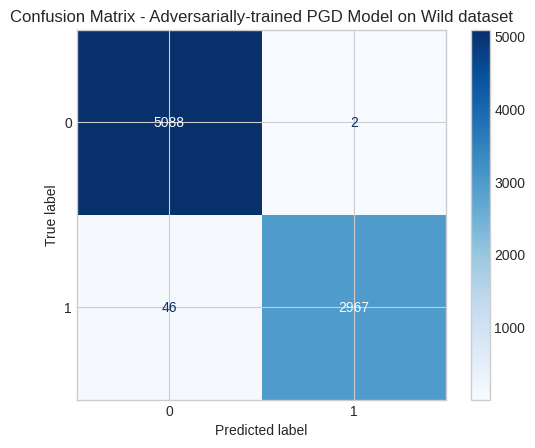

In [117]:
# Confusion matrix
cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix - Adversarially-trained PGD Model on Wild dataset")
plt.show()

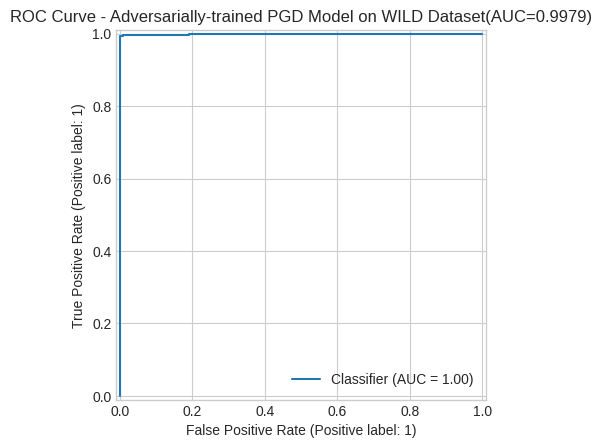

In [118]:
# ROC curve
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title(f"ROC Curve - Adversarially-trained PGD Model on WILD Dataset(AUC={roc_auc:.4f})")
plt.show()

### FGSM Model

In [119]:
fgsm_model = copy.deepcopy(base_model)
fgsm_model = fgsm_model.to(device)


In [120]:
optimizer_fgsm = optim.Adam(fgsm_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [121]:
wild_epoch_metrics_fgsm = []

In [122]:
for epoch in range(num_epochs_fgsm):
    fgsm_model.train()
    total_loss = 0
    for Xb, yb in train_loader_wild:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1).float()

        # Generate FGSM adversarial batch
        Xb_adv = fgsm_attack(fgsm_model, Xb, yb, eps=0.03, device=device)

        # Forward + backward
        preds = fgsm_model(Xb_adv)
        loss = criterion(preds, yb)
        optimizer_fgsm.zero_grad()
        loss.backward()
        optimizer_fgsm.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_wild)

    # ----- Validation -----
    fgsm_model.eval()
    y_true, y_pred, y_scores = [], [], []
    val_loss = 0.0
    start_time = time.time()
    with torch.no_grad():
        for Xv, yv in val_loader_wild:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1).float()

            logits = fgsm_model(Xv)
            val_loss += criterion(logits, yv).item()
            probs = torch.sigmoid(logits)
            preds_class = (probs > 0.5).int()

            y_true.extend(yv.cpu().numpy().flatten().tolist())
            y_pred.extend(preds_class.cpu().numpy().flatten().tolist())
            y_scores.extend(probs.cpu().numpy().flatten().tolist())

    end_time = time.time()
    avg_val_loss = val_loss / len(val_loader_wild)
    avg_latency = (end_time - start_time) / len(val_loader_wild.dataset)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_scores)
    eer, eer_threshold = compute_eer(y_true, np.array(y_scores))
    asr = compute_asr(y_true, y_pred)
    far = compute_far(y_true, y_pred)
    frr = compute_frr(y_true, y_pred)

    epoch_metrics = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "eer": eer,
        "roc_auc": roc_auc,
        "asr": asr,
        "far": far,
        "frr": frr,
        "latency_per_sample": avg_latency
    }
    wild_epoch_metrics_fgsm.append(epoch_metrics)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | "
          f"EER: {eer:.4f} | ASR: {asr:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | ROC-AUC: {roc_auc:.4f} | "
          f"Latency: {avg_latency*1000:.2f} ms/sample")
    print('')


Epoch 1 | Train Loss: 0.1237 | Val Loss: 0.0760 | Acc: 0.9772 | Prec: 0.9466 | Rec: 0.9947 | F1: 0.9701 | EER: 0.0124 | ASR: 0.0053 | FAR: 0.0332 | FRR: 0.0053 | ROC-AUC: 0.9979 | Latency: 0.07 ms/sample

Epoch 2 | Train Loss: 0.0358 | Val Loss: 0.0618 | Acc: 0.9824 | Prec: 0.9588 | Rec: 0.9954 | F1: 0.9767 | EER: 0.0071 | ASR: 0.0046 | FAR: 0.0253 | FRR: 0.0046 | ROC-AUC: 0.9985 | Latency: 0.07 ms/sample

Epoch 3 | Train Loss: 0.0236 | Val Loss: 0.0914 | Acc: 0.9756 | Prec: 0.9425 | Rec: 0.9950 | F1: 0.9680 | EER: 0.0084 | ASR: 0.0050 | FAR: 0.0360 | FRR: 0.0050 | ROC-AUC: 0.9981 | Latency: 0.07 ms/sample

Epoch 4 | Train Loss: 0.0160 | Val Loss: 0.0559 | Acc: 0.9883 | Prec: 0.9725 | Rec: 0.9967 | F1: 0.9844 | EER: 0.0051 | ASR: 0.0033 | FAR: 0.0167 | FRR: 0.0033 | ROC-AUC: 0.9989 | Latency: 0.07 ms/sample

Epoch 5 | Train Loss: 0.0115 | Val Loss: 0.0866 | Acc: 0.9806 | Prec: 0.9542 | Rec: 0.9957 | F1: 0.9745 | EER: 0.0067 | ASR: 0.0043 | FAR: 0.0283 | FRR: 0.0043 | ROC-AUC: 0.9986 | 

In [123]:
pd.DataFrame(wild_epoch_metrics_fgsm).head()

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample
0,1,0.123703,0.075961,0.977169,0.946620,0.994690,0.970060,0.012377,0.997935,0.005310,0.033202,0.005310,0.000073
1,2,0.035778,0.061846,0.982352,0.958760,0.995353,0.976714,0.007073,0.998467,0.004647,0.025344,0.004647,0.000071
2,3,0.023596,0.091372,0.975565,0.942471,0.995022,0.968034,0.008448,0.998091,0.004978,0.035953,0.004978,0.000073
3,4,0.015971,0.055854,0.988276,0.972474,0.996681,0.984429,0.005108,0.998918,0.003319,0.016699,0.003319,0.000073
4,5,0.011505,0.086618,0.980624,0.954198,0.995685,0.974501,0.006680,0.998557,0.004315,0.028291,0.004315,0.000076


In [124]:
final_y_true = y_true
final_y_pred = y_pred
final_y_scores = y_scores

In [125]:
print("FGSM Adversarially-trained Model Classification Report:")
print(classification_report(final_y_true, final_y_pred, digits=4))

FGSM Adversarially-trained Model Classification Report:
              precision    recall  f1-score   support

         0.0     0.9969    0.6994    0.8221      5090
         1.0     0.6624    0.9963    0.7958      3013

    accuracy                         0.8098      8103
   macro avg     0.8297    0.8479    0.8089      8103
weighted avg     0.8725    0.8098    0.8123      8103



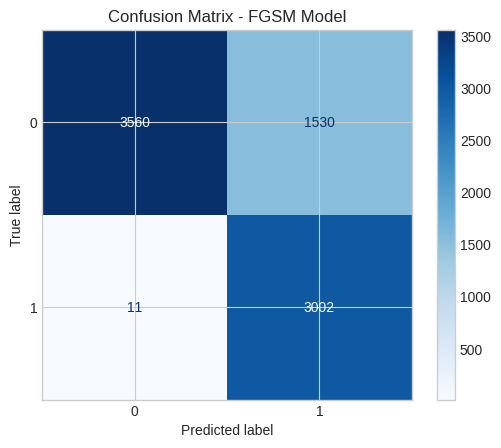

In [126]:
# Confusion matrix
cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlOrBr")
plt.title("Confusion Matrix - FGSM Model")
plt.show()


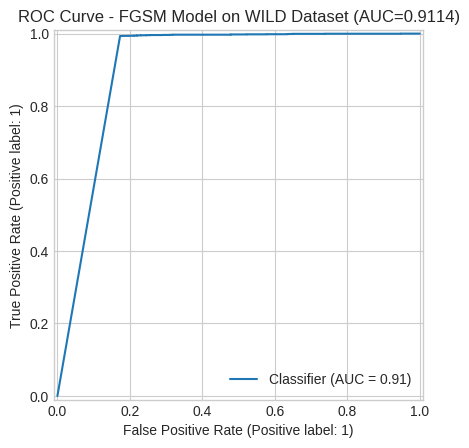

In [127]:
# ROC curve
RocCurveDisplay.from_predictions(final_y_true, final_y_scores)
plt.title(f"ROC Curve - FGSM Model on WILD Dataset (AUC={roc_auc:.4f})")
plt.show()


In [128]:
wild_epoch_metrics_df = pd.DataFrame(wild_epoch_metrics)
wild_epoch_metrics_adv_df = pd.DataFrame(wild_epoch_metrics_adv)
wild_epoch_metrics_fgsm_df = pd.DataFrame(wild_epoch_metrics_fgsm)

In [129]:
# Add a 'model' column to each
wild_epoch_metrics_df['model'] = 'Baseline'
wild_epoch_metrics_adv_df['model'] = 'PGD'
wild_epoch_metrics_fgsm_df['model'] = 'FGSM'

In [130]:
df_comparison_2 = pd.concat(
    [
        wild_epoch_metrics_df,wild_epoch_metrics_adv_df,wild_epoch_metrics_fgsm_df
    ],ignore_index=True
)

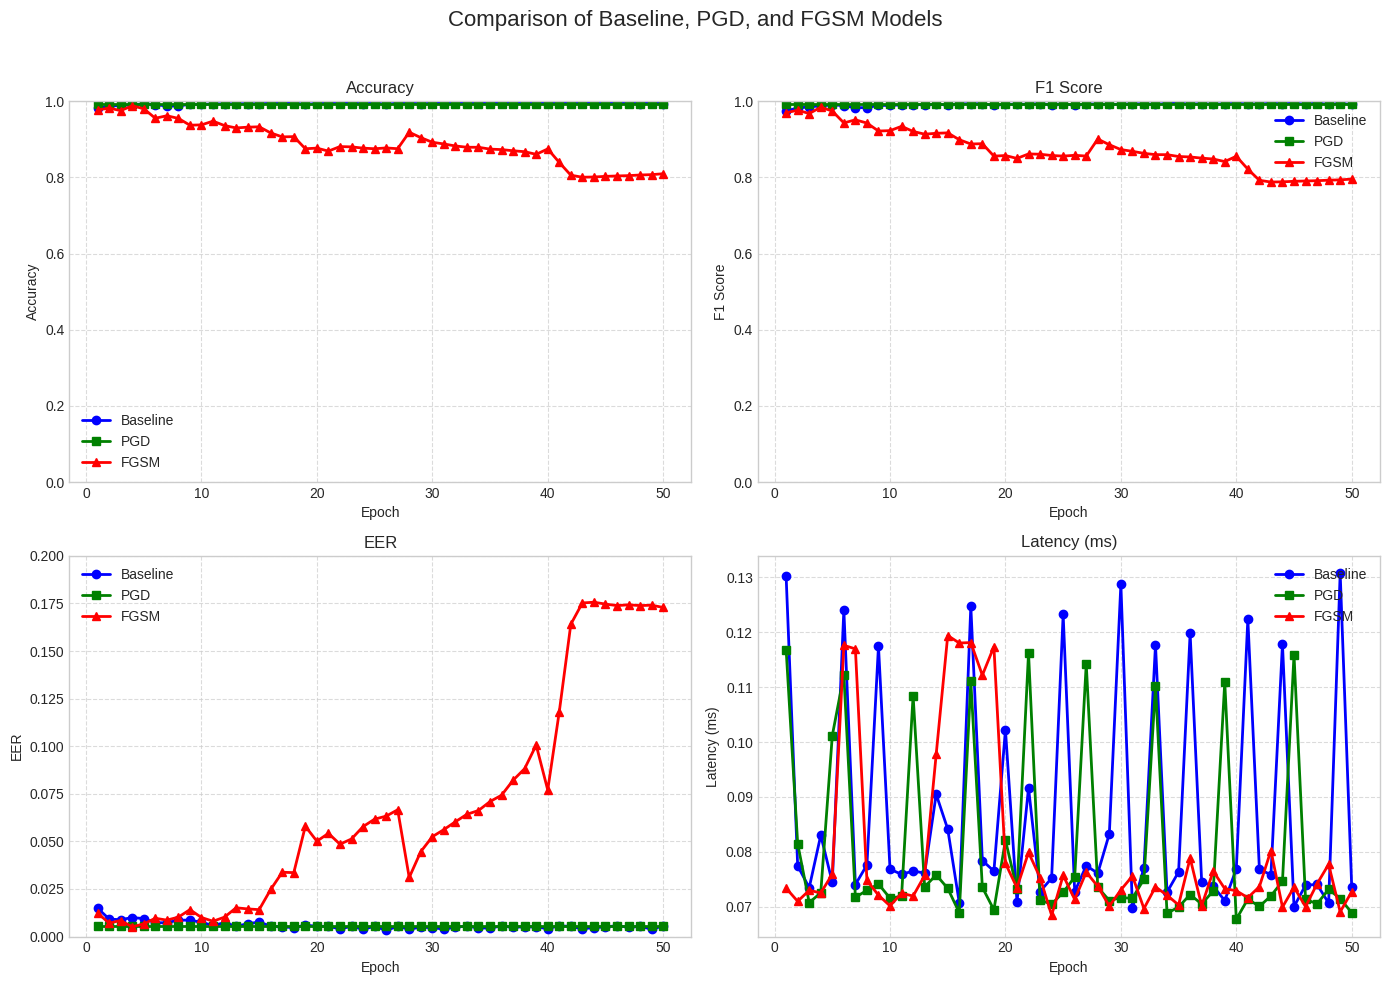

In [131]:
import matplotlib.pyplot as plt

# Define colors and markers for consistency
colors = {'Baseline':'blue', 'PGD':'green', 'FGSM':'red'}
markers = {'Baseline':'o', 'PGD':'s', 'FGSM':'^'}

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Comparison of Baseline, PGD, and FGSM Models', fontsize=16)

metrics = ['accuracy','f1_score','eer','latency_per_sample']
ylabels = ['Accuracy','F1 Score','EER','Latency (ms)']
ylim_vals = [(0,1),(0,1),(0,0.2),None]  # set limits for first three, last auto

for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]
    ylabel = ylabels[i]
    ylim = ylim_vals[i]

    for model_name in df_comparison_2['model'].unique():
        model_data = df_comparison_2[df_comparison['model'] == model_name]
        y_values = model_data[metric]
        if metric == 'latency_per_sample':  # convert to ms
            y_values = y_values * 1000
        ax.plot(model_data['epoch'], y_values, marker=markers[model_name],
                color=colors[model_name], label=model_name, linewidth=2)

    ax.set_title(ylabel)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [132]:
df_comparison_2['Dataset'] = "WILD"
df_comparison['Dataset'] = 'ASVSpoof2019'

In [133]:
main_df = pd.concat(
    [df_comparison_2,df_comparison],ignore_index = True
)

In [134]:
main_df

,epoch,train_loss,val_loss,accuracy,precision,recall,f1_score,eer,roc_auc,asr,far,frr,latency_per_sample,model,Dataset
0,1,0.065474,0.017221,0.982352,0.997573,0.954862,0.975750,0.014931,0.995854,0.045138,0.001375,0.045138,0.000130,Baseline,WILD
1,2,0.013059,0.010998,0.986672,0.997602,0.966479,0.981794,0.009234,0.998463,0.033521,0.001375,0.033521,0.000077,Baseline,WILD
2,3,0.009849,0.006649,0.989757,0.998639,0.973780,0.986053,0.008841,0.998052,0.026220,0.000786,0.026220,0.000073,Baseline,WILD
3,4,0.009225,0.006590,0.990991,0.999321,0.976435,0.987746,0.010020,0.997630,0.023565,0.000393,0.023565,0.000083,Baseline,WILD
4,5,0.008323,0.005995,0.993459,0.997981,0.984401,0.991145,0.009430,0.998844,0.015599,0.001179,0.015599,0.000074,Baseline,WILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,46,0.004352,21.287145,0.897104,0.897759,0.999100,0.945723,0.982407,0.507538,0.000900,0.993402,0.000900,0.000056,FGSM,ASVSpoof2019
296,47,0.005030,21.922736,0.897104,0.897656,0.999244,0.945730,0.985234,0.506035,0.000756,0.994659,0.000756,0.000036,FGSM,ASVSpoof2019
297,48,0.004011,21.679204,0.897072,0.897833,0.998956,0.945699,0.981778,0.507709,0.001044,0.992460,0.001044,0.000038,FGSM,ASVSpoof2019
298,49,0.004397,21.585274,0.897265,0.897982,0.998992,0.945798,0.978008,0.509575,0.001008,0.990889,0.001008,0.000035,FGSM,ASVSpoof2019


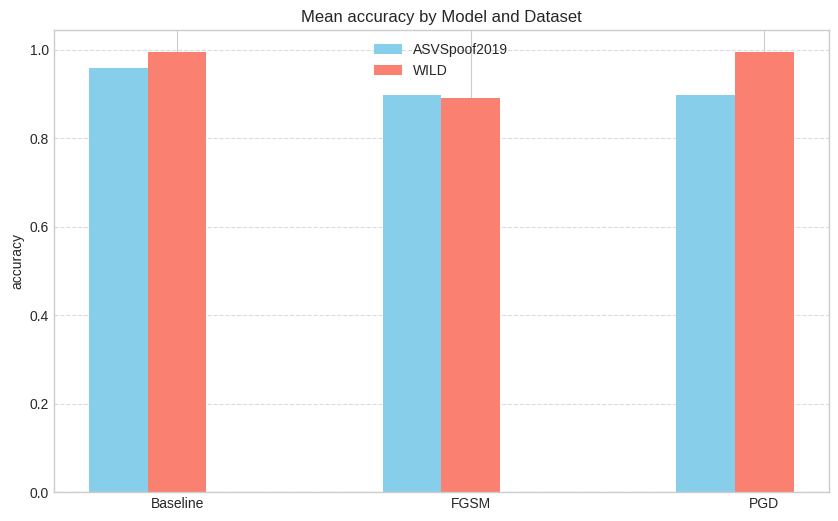

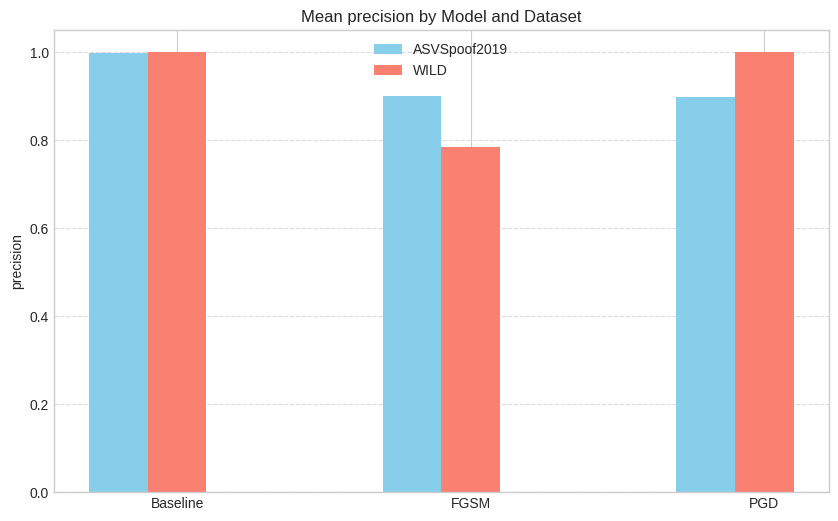

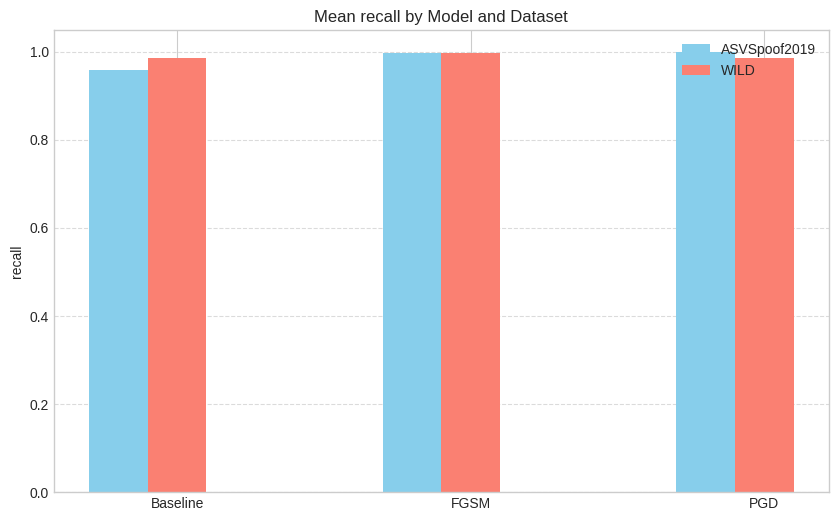

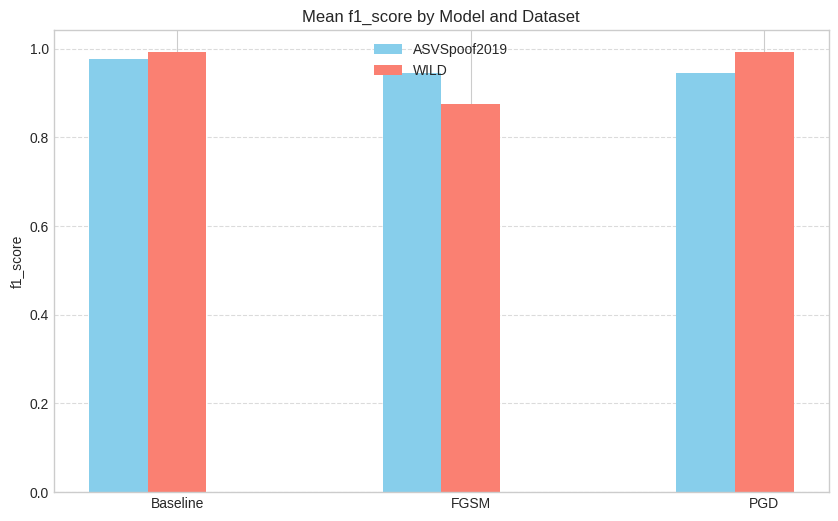

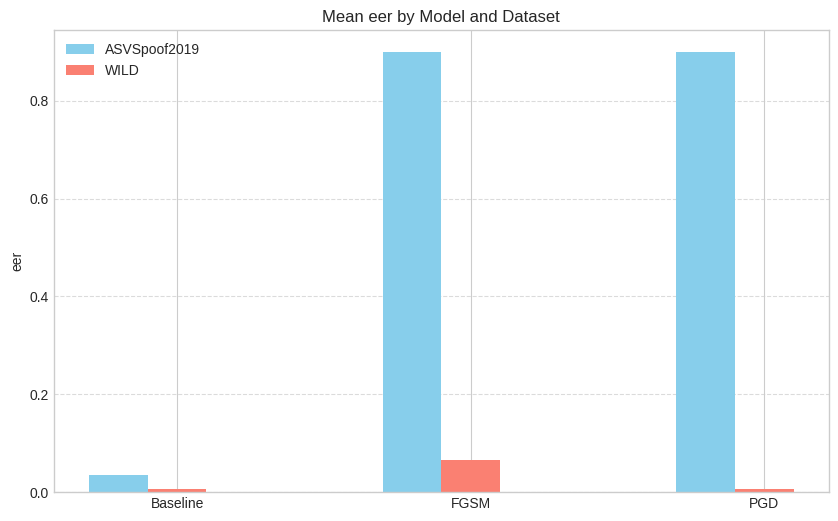

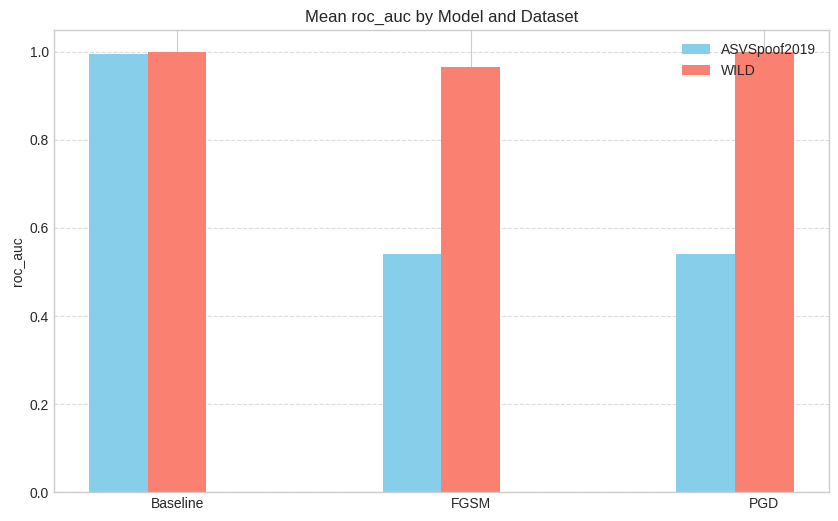

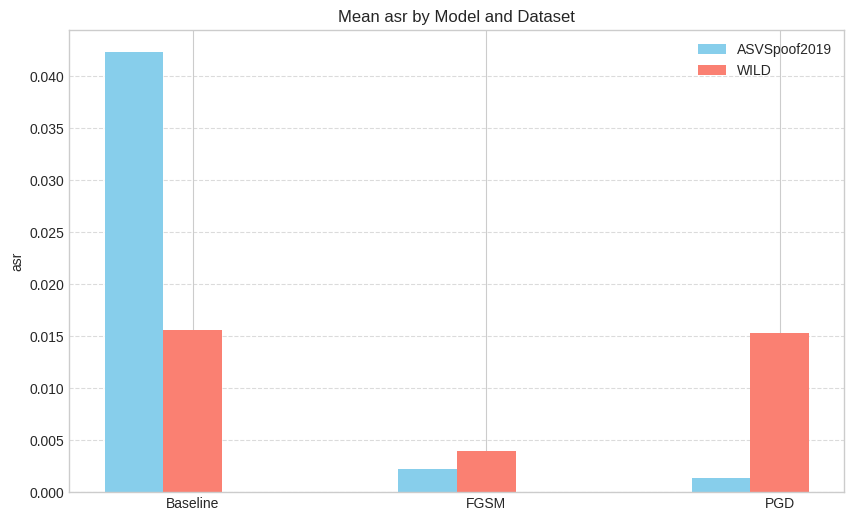

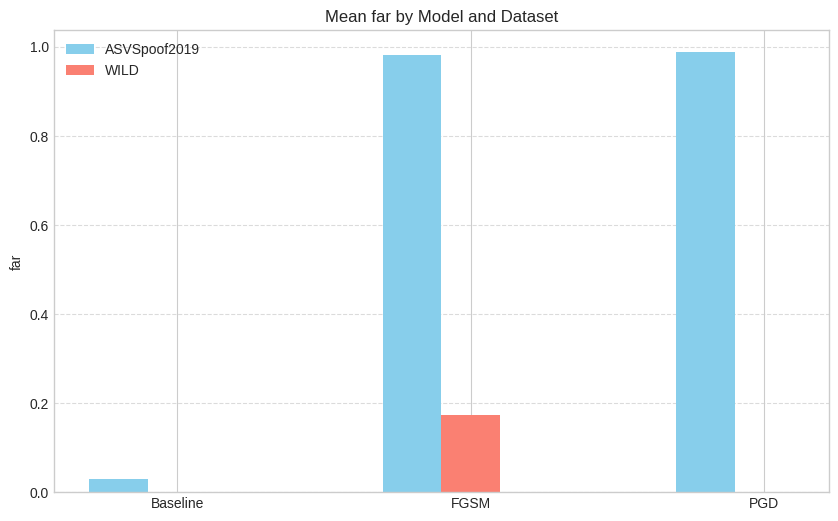

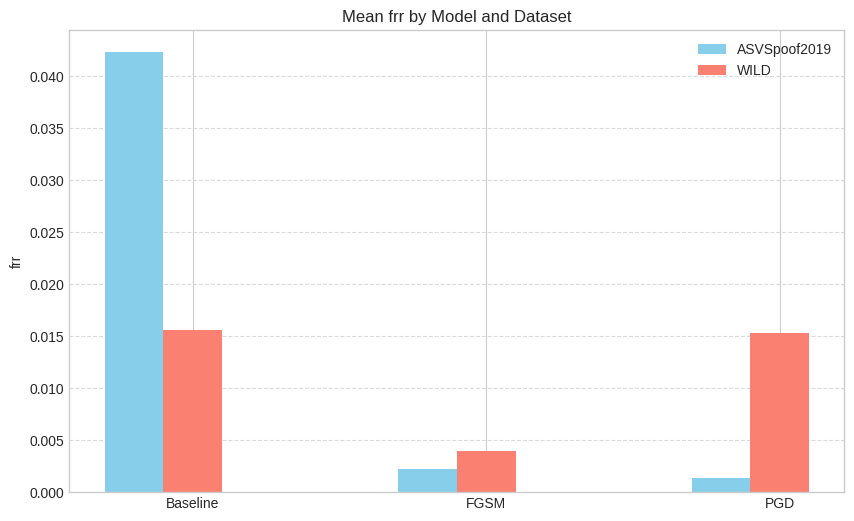

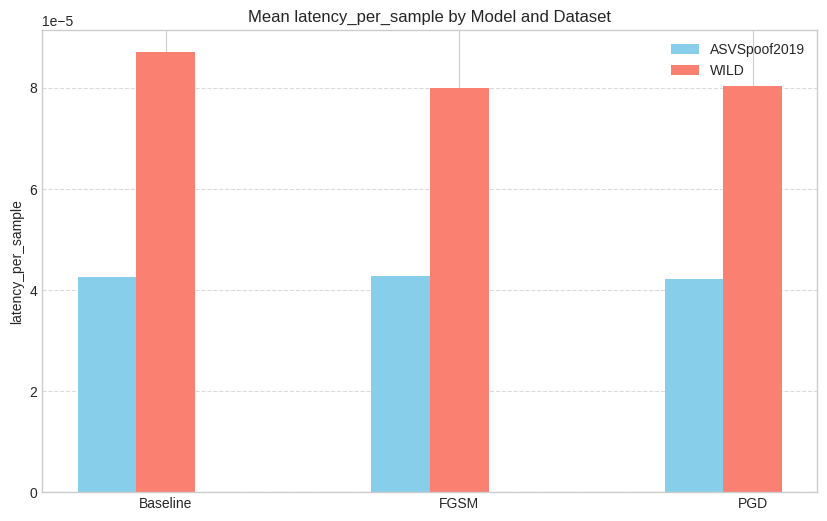

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Model and Dataset, compute mean of metrics
metrics_to_plot = ['accuracy','precision','recall','f1_score','eer','roc_auc','asr','far','frr','latency_per_sample']
grouped_df = main_df.groupby(['model','Dataset'])[metrics_to_plot].mean().reset_index()

# Set up bar width and x locations
bar_width = 0.2
x = range(len(grouped_df['model'].unique()))

# Function to plot each metric
def plot_metric(metric_name):
    plt.figure(figsize=(10,6))

    datasets = grouped_df['Dataset'].unique()
    models = grouped_df['model'].unique()
    colors = ['skyblue', 'salmon', 'lightgreen']

    for i, dataset in enumerate(datasets):
        dataset_data = grouped_df[grouped_df['Dataset']==dataset]
        plt.bar([p + i*bar_width for p in range(len(models))],
                dataset_data[metric_name],
                width=bar_width,
                color=colors[i],
                label=dataset)

    plt.xticks([p + bar_width for p in range(len(models))], models)
    plt.ylabel(metric_name)
    plt.title(f'Mean {metric_name} by Model and Dataset')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot all metrics except 'epoch'
for metric in metrics_to_plot:
    plot_metric(metric)


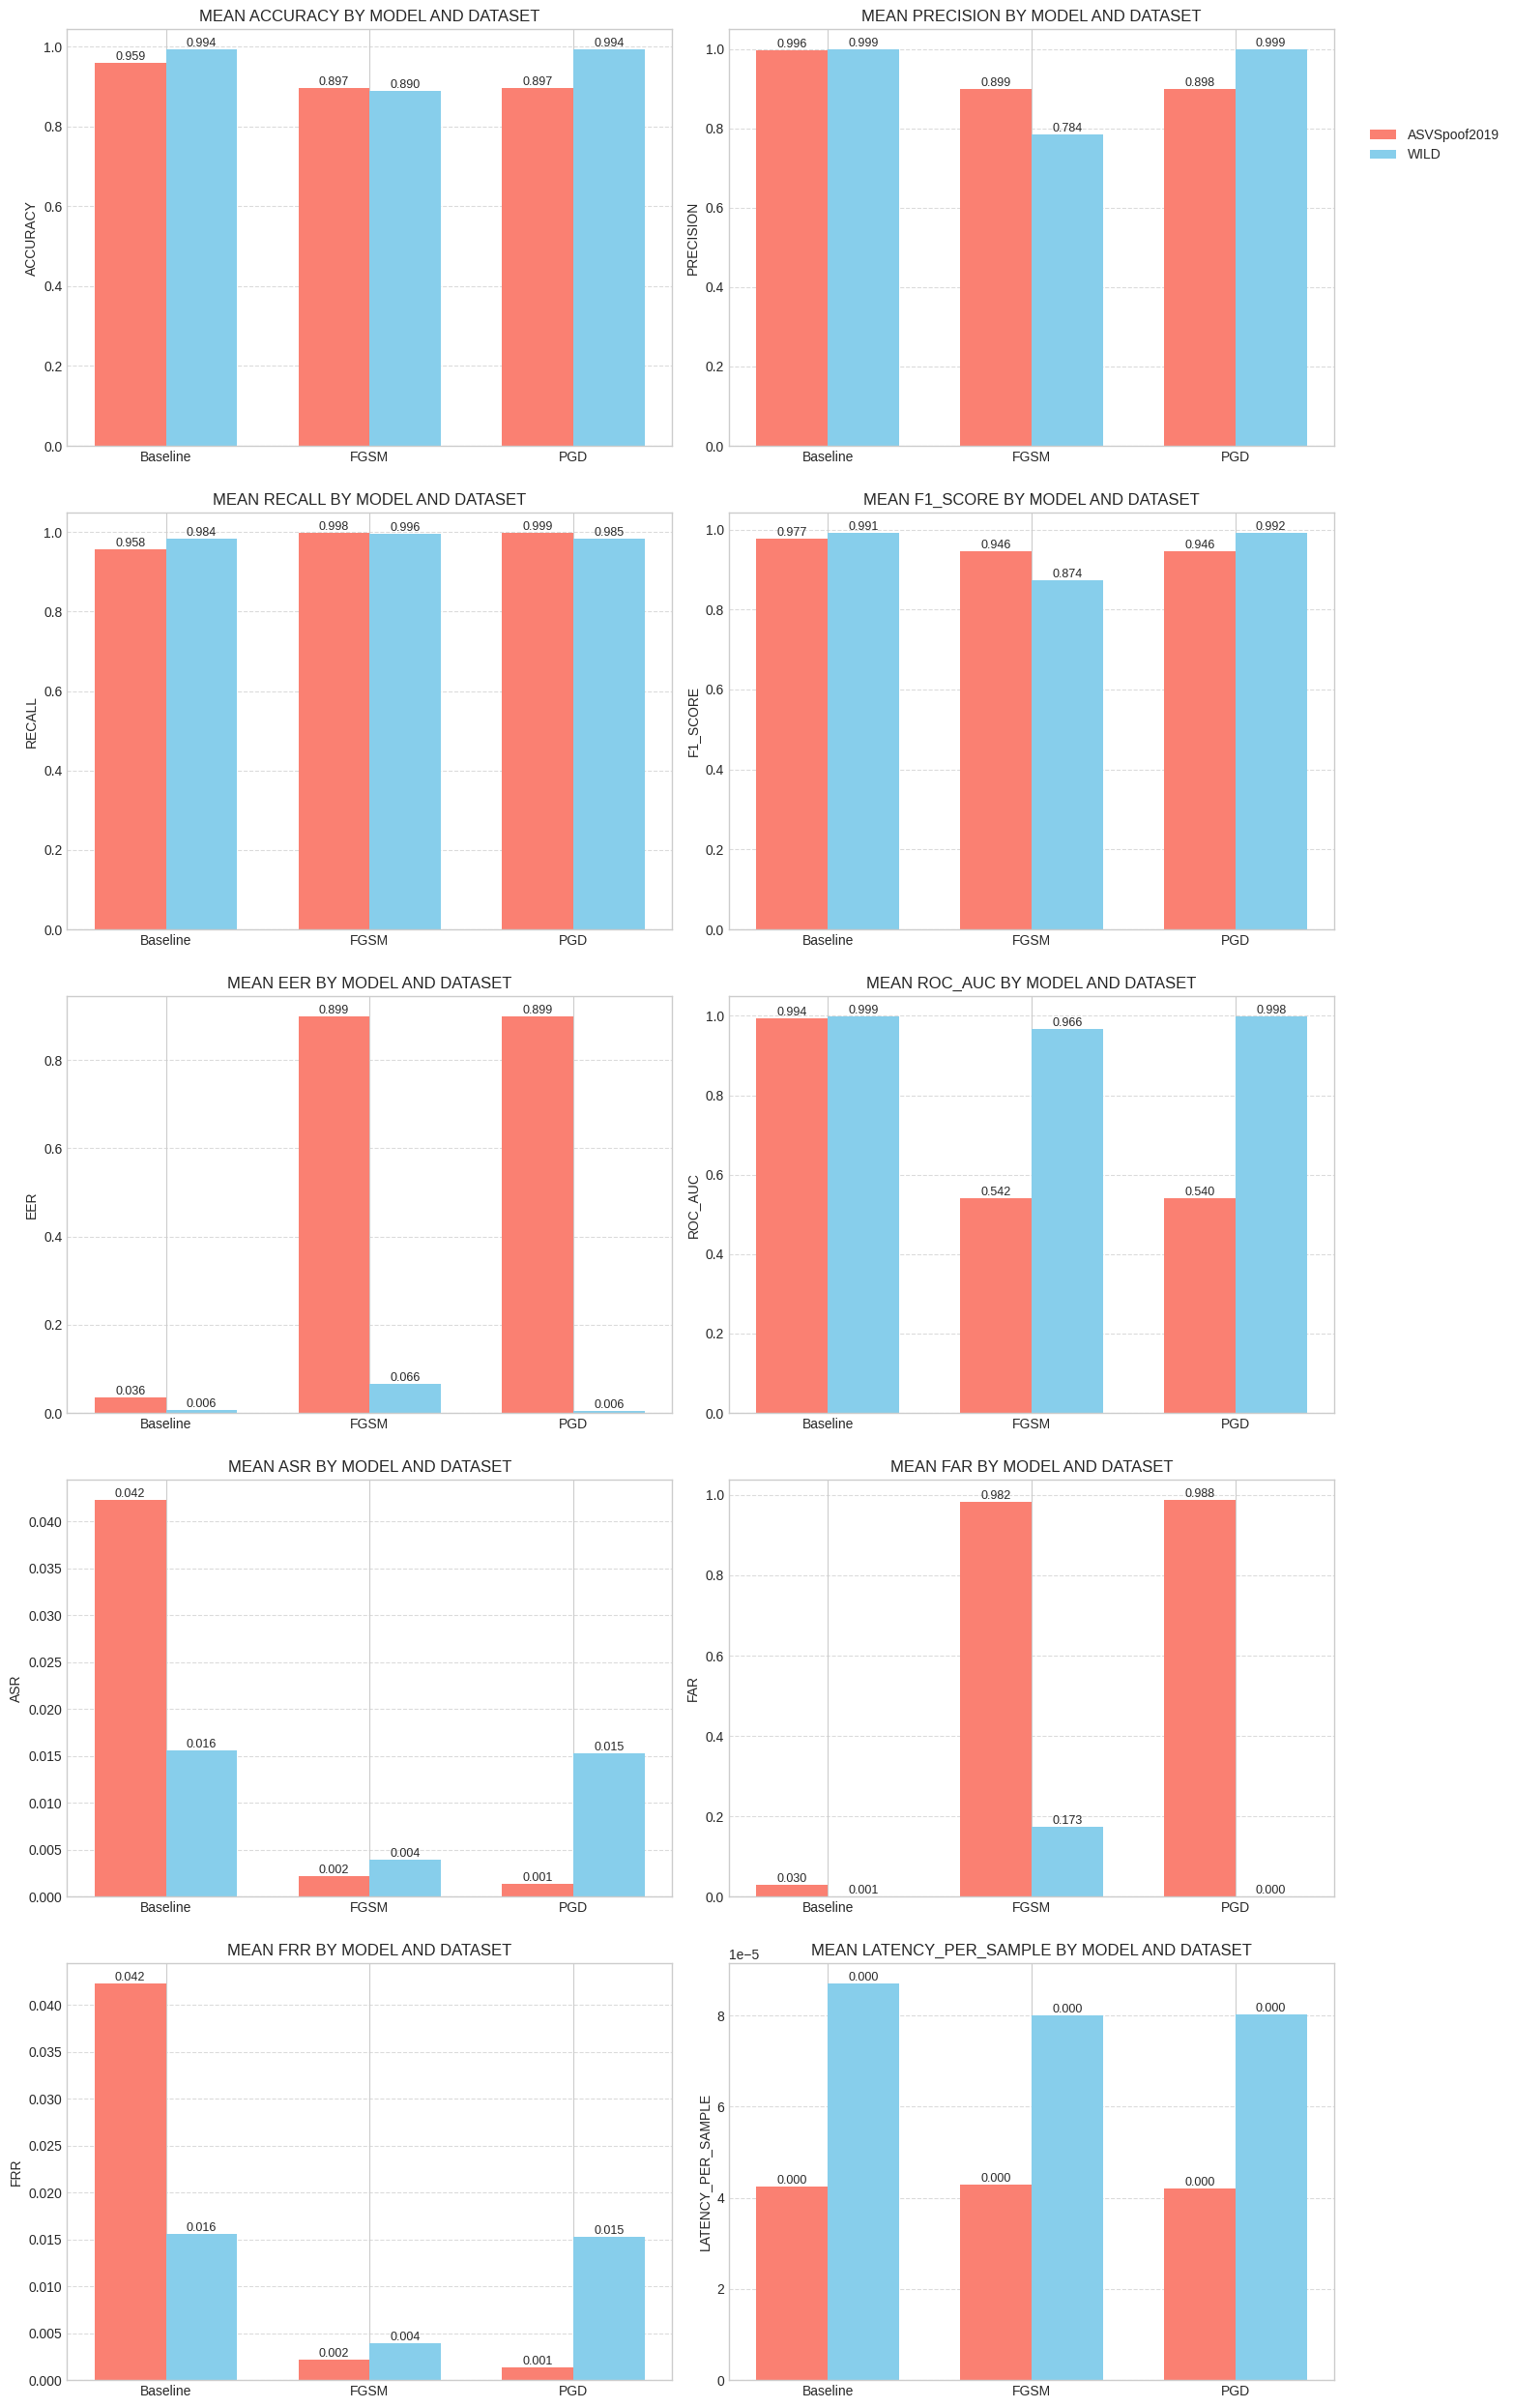

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by Model and Dataset, compute mean of metrics
metrics_to_plot = ['accuracy','precision','recall','f1_score','eer','roc_auc','asr','far','frr','latency_per_sample']
grouped_df = main_df.groupby(['model','Dataset'])[metrics_to_plot].mean().reset_index()

# Bar colors for datasets
dataset_colors = {'WILD':'skyblue', 'ASVSpoof2019':'salmon'}

# Create subplots: 2 plots per row
n_metrics = len(metrics_to_plot)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*5))
axes = axes.flatten()

bar_width = 0.35

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    models = grouped_df['model'].unique()
    datasets = grouped_df['Dataset'].unique()

    for i, dataset in enumerate(datasets):
        dataset_data = grouped_df[grouped_df['Dataset']==dataset]
        x_pos = np.arange(len(models)) + i*bar_width
        bars = ax.bar(x_pos, dataset_data[metric], width=bar_width, color=dataset_colors[dataset], label=dataset)

        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xticks(np.arange(len(models)) + bar_width/2)
    ax.set_xticklabels(models)
    ax.set_ylabel(metric.upper())
    ax.set_title(f'MEAN {metric.upper()} BY MODEL AND DATASET', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Place a single legend for all subplots outside the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 0.95), fontsize=10)

# Hide any unused axes
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
